# <font color="red">Boston Housing Prediction</font>

## Import the Library

In [ ]:
# Data manipulation and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, label_binarize

# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from lightgbm import LGBMClassifier

# Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Utilities
import joblib
import math
import os
import json
from datetime import datetime
from itertools import cycle

## Scaler Selection

In [ ]:
scaler_types = {
    'minmax': MinMaxScaler(),
    'standard': StandardScaler(),
    'robust': RobustScaler()
}

scaler_name = "robust"
scaler_selection = lambda: scaler_types[scaler_name]

## Trained Model and History Saving

These code are used to manage the best model and its performance for reuse or further research purpose

### Directory

In [162]:
# Model tracking configuration
MODEL_REGISTRY_FILE = "history_registry/model_registry_regression.csv"
MODELS_DIR = "saved_models_regression"

In [163]:
# Model tracking configuration for classification
MODEL_REGISTRY_FILE_CLASSIFICATION = "history_registry/model_registry_classification.csv"
MODELS_DIR_CLASSIFICATION = "saved_models_classification"

### Define the Registry or History File

In [164]:
def load_or_create_registry_regression():
    """Load existing model registry or create new one"""
    try:
        return pd.read_csv(MODEL_REGISTRY_FILE)
    except FileNotFoundError:
        return pd.DataFrame(columns=[
            'model_name', 'scaler_type', 'mse', 'mae', 'rmse', 'r2', 'timestamp', 
            'model_path', 'scaler_path', 'parameters'
        ])

In [165]:
def load_or_create_registry_classification():
    """Load existing model registry or create new one for classification"""
    try:
        return pd.read_csv(MODEL_REGISTRY_FILE_CLASSIFICATION)
    except FileNotFoundError:
        return pd.DataFrame(columns=[
            'model_name', 'scaler_type', 'accuracy', 'precision', 'recall', 'f1', 'timestamp',
            'model_path', 'scaler_path', 'parameters'
        ])

### Model Saving only for the Best Performance

In [166]:
def save_model_if_better_regression(model_name, model, scaler, mse, mae, rmse, r2, parameters=None):
    """Save model only if it performs better than existing version for the same scaler"""
    
    # Create directories
    os.makedirs(MODELS_DIR, exist_ok=True)
    os.makedirs(os.path.dirname(MODEL_REGISTRY_FILE), exist_ok=True)
    
    # Load registry
    registry = load_or_create_registry_regression()
    
    # Get current scaler type
    current_scaler_type = scaler_name
    
    # Check if model exists for the same scaler
    existing_model = registry[(registry['model_name'] == model_name) & 
                             (registry['scaler_type'] == current_scaler_type)]
    
    should_save = False
    old_model_path = None
    old_scaler_path = None
    
    if existing_model.empty:
        print(f"{model_name} ({current_scaler_type}): First time training - saving model")
        should_save = True
    else:
        existing_mse = existing_model['mse'].iloc[0]
        existing_r2 = existing_model['r2'].iloc[0]
        
        # Store old file paths for deletion
        old_model_path = existing_model['model_path'].iloc[0]
        old_scaler_path = existing_model['scaler_path'].iloc[0]
        
        # Check if current model is better (lower MSE and higher R2)
        if mse < existing_mse and r2 > existing_r2:
            print(f"{model_name} ({current_scaler_type}): Better performance - updating model")
            print(f"   MSE: {existing_mse:.4f} → {mse:.4f} (↓)")
            print(f"   R2:  {existing_r2:.4f} → {r2:.4f} (↑)")
            should_save = True
        else:
            print(f"{model_name} ({current_scaler_type}): No improvement - keeping existing model")
            print(f"   Current MSE: {mse:.4f} vs Best: {existing_mse:.4f}")
            print(f"   Current R2:  {r2:.4f} vs Best: {existing_r2:.4f}")
    
    if should_save:
        # Delete old model files if they exist
        if old_model_path and os.path.exists(old_model_path):
            try:
                os.remove(old_model_path)
                print(f"    Deleted old model: {old_model_path}")
            except Exception as e:
                print(f"    Warning: Could not delete old model file: {e}")
                
        if old_scaler_path and os.path.exists(old_scaler_path):
            try:
                os.remove(old_scaler_path)
                print(f"    Deleted old scaler: {old_scaler_path}")
            except Exception as e:
                print(f"    Warning: Could not delete old scaler file: {e}")
        
        # Save new model and scaler
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model_filename = f"{model_name.lower().replace(' ', '_')}_{current_scaler_type}_{timestamp}.pkl"
        scaler_filename = f"{model_name.lower().replace(' ', '_')}_scaler_{current_scaler_type}_{timestamp}.pkl"
        
        model_path = os.path.join(MODELS_DIR, model_filename)
        scaler_path = os.path.join(MODELS_DIR, scaler_filename)
        
        joblib.dump(model, model_path)
        joblib.dump(scaler, scaler_path)
        
        # Remove old entry from registry (if exists)
        registry = registry[~((registry['model_name'] == model_name) & 
                             (registry['scaler_type'] == current_scaler_type))]
        
        # Add new entry to registry
        new_entry = pd.DataFrame([{
            'model_name': model_name,
            'scaler_type': current_scaler_type,
            'mse': mse,
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'timestamp': timestamp,
            'model_path': model_path,
            'scaler_path': scaler_path,
            'parameters': json.dumps(parameters) if parameters else None
        }])
        
        registry = pd.concat([registry, new_entry], ignore_index=True)
        registry.to_csv(MODEL_REGISTRY_FILE, index=False)
        
        print(f"    New model saved to: {model_path}")
        print(f"    New scaler saved to: {scaler_path}")
    
    return should_save

In [167]:
def save_model_if_better_classification(model_name, model, scaler, accuracy, precision, recall, f1, parameters=None):
    """Save classification model only if it performs better than existing version for the same scaler"""
    
    # Create directories
    os.makedirs(MODELS_DIR_CLASSIFICATION, exist_ok=True)
    os.makedirs(os.path.dirname(MODEL_REGISTRY_FILE_CLASSIFICATION), exist_ok=True)
    
    # Load registry
    registry = load_or_create_registry_classification()
    
    # Get current scaler type
    current_scaler_type = scaler_name
    
    # Check if model exists for the same scaler
    existing_model = registry[(registry['model_name'] == model_name) & 
                             (registry['scaler_type'] == current_scaler_type)]
    
    should_save = False
    old_model_path = None
    old_scaler_path = None
    
    if existing_model.empty:
        print(f"{model_name} ({current_scaler_type}): First time training - saving model")
        should_save = True
    else:
        existing_accuracy = existing_model['accuracy'].iloc[0]
        
        # Store old file paths for deletion
        old_model_path = existing_model['model_path'].iloc[0]
        old_scaler_path = existing_model['scaler_path'].iloc[0]
        
        # Check if current model is better (higher accuracy)
        if accuracy > existing_accuracy:
            print(f"{model_name} ({current_scaler_type}): Better performance - updating model")
            print(f"   Accuracy: {existing_accuracy:.4f} → {accuracy:.4f} (↑)")
            should_save = True
        else:
            print(f"{model_name} ({current_scaler_type}): No improvement - keeping existing model")
            print(f"   Current Accuracy: {accuracy:.4f} vs Best: {existing_accuracy:.4f}")
    
    if should_save:
        # Delete old model files if they exist
        if old_model_path and os.path.exists(old_model_path):
            try:
                os.remove(old_model_path)
                print(f"    Deleted old model: {old_model_path}")
            except Exception as e:
                print(f"    Warning: Could not delete old model file: {e}")
                
        if old_scaler_path and os.path.exists(old_scaler_path):
            try:
                os.remove(old_scaler_path)
                print(f"    Deleted old scaler: {old_scaler_path}")
            except Exception as e:
                print(f"    Warning: Could not delete old scaler file: {e}")
        
        # Save new model and scaler
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model_filename = f"{model_name.lower().replace(' ', '_')}_{current_scaler_type}_{timestamp}.pkl"
        scaler_filename = f"{model_name.lower().replace(' ', '_')}_scaler_{current_scaler_type}_{timestamp}.pkl"
        
        model_path = os.path.join(MODELS_DIR_CLASSIFICATION, model_filename)
        scaler_path = os.path.join(MODELS_DIR_CLASSIFICATION, scaler_filename)
        
        joblib.dump(model, model_path)
        joblib.dump(scaler, scaler_path)
        
        # Remove old entry from registry (if exists)
        registry = registry[~((registry['model_name'] == model_name) & 
                             (registry['scaler_type'] == current_scaler_type))]
        
        # Add new entry to registry
        new_entry = pd.DataFrame([{
            'model_name': model_name,
            'scaler_type': current_scaler_type,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'timestamp': timestamp,
            'model_path': model_path,
            'scaler_path': scaler_path,
            'parameters': json.dumps(parameters) if parameters else None
        }])
        
        registry = pd.concat([registry, new_entry], ignore_index=True)
        registry.to_csv(MODEL_REGISTRY_FILE_CLASSIFICATION, index=False)
        
        print(f"    New model saved to: {model_path}")
        print(f"    New scaler saved to: {scaler_path}")
    
    return should_save

### Show the history in descending order of R2 & F1

In [168]:
def show_model_registry_regression():
    """Display current model registry in descending order of R2"""
    try:
        registry = pd.read_csv(MODEL_REGISTRY_FILE)
        if not registry.empty:
            # Sort by R2 in descending order (best models first)
            registry_sorted = registry.sort_values('r2', ascending=False)
            
            print("\n" + "="*90)
            print("MODEL REGISTRY - BEST PERFORMING MODELS (Sorted by R2)")
            print("="*90)
            display_cols = ['model_name', 'scaler_type', 'mse', 'mae', 'rmse', 'r2', 'timestamp']
            print(registry_sorted[display_cols].to_string(index=False))
        else:
            print("No models saved yet.")
    except FileNotFoundError:
        print("No model registry found.")

In [169]:
def show_model_registry_classification():
    """Display current classification model registry in descending order of F1"""
    try:
        registry = pd.read_csv(MODEL_REGISTRY_FILE_CLASSIFICATION)
        if not registry.empty:
            # Sort by F1 in descending order (best models first)
            registry_sorted = registry.sort_values('f1', ascending=False)
            
            print("\n" + "="*90)
            print("CLASSIFICATION MODEL REGISTRY - BEST PERFORMING MODELS (Sorted by F1)")
            print("="*90)
            display_cols = ['model_name', 'scaler_type', 'accuracy', 'precision', 'recall', 'f1', 'timestamp']
            print(registry_sorted[display_cols].to_string(index=False))
        else:
            print("No classification models saved yet.")
    except FileNotFoundError:
        print("No classification model registry found.")

### For Model Parameters

In [170]:
def view_model_parameters_regression(model_name=None, scaler_type=None):
    """View parameters of saved models"""
    try:
        registry = pd.read_csv(MODEL_REGISTRY_FILE)
        
        if model_name:
            if scaler_type:
                model_info = registry[(registry['model_name'] == model_name) & 
                                     (registry['scaler_type'] == scaler_type)]
                if model_info.empty:
                    print(f"No model found with name: {model_name} and scaler: {scaler_type}")
                    return
            else:
                model_info = registry[registry['model_name'] == model_name]
                if model_info.empty:
                    print(f"No model found with name: {model_name}")
                    return
            
            for _, row in model_info.iterrows():
                params_json = row['parameters']
                print(f"\n{row['model_name']} ({row['scaler_type']}) Parameters:")
                print("="*60)
                
                if params_json:
                    params = json.loads(params_json)
                    
                    if 'best_params' in params:
                        print("OPTIMIZED PARAMETERS:")
                        for key, value in params['best_params'].items():
                            print(f"   {key}: {value}")
                        print(f"\nCross-validation score: {params.get('cv_score', 'N/A')}")
                        
                        if 'all_params' in params:
                            print(f"\nCOMPLETE PARAMETER SET:")
                            all_params = params['all_params']
                            for key, value in sorted(all_params.items()):
                                print(f"   {key}: {value}")
                    else:
                        print("MODEL PARAMETERS:")
                        for key, value in sorted(params.items()):
                            print(f"   {key}: {value}")
                else:
                    print("No parameters saved for this model")
                print(f"Performance: MSE={row['mse']:.4f}, R2={row['r2']:.4f}")
        else:
            print("\n" + "="*90)
            print("ALL SAVED MODELS AND THEIR PARAMETERS")
            print("="*90)
            
            # Sort by R2 score descending (best first)
            registry_sorted = registry.sort_values('r2', ascending=False)
            
            for _, row in registry_sorted.iterrows():
                print(f"\n{row['model_name']} ({row['scaler_type']})")
                print(f"   Performance: MSE={row['mse']:.4f}, R2={row['r2']:.4f}")
                
                if row['parameters']:
                    params = json.loads(row['parameters'])
                    
                    if 'best_params' in params:
                        print("   Optimized Parameters:")
                        for key, value in params['best_params'].items():
                            print(f"      {key}: {value}")
                        print(f"   CV Score: {params.get('cv_score', 'N/A'):.4f}")
                    else:
                        print("   All Parameters:")
                        for key, value in sorted(params.items()):
                            if key not in ['algorithm']:
                                print(f"      {key}: {value}")
                else:
                    print("   No parameters saved")
                print(f"   Saved: {row['timestamp']}")
                
    except Exception as e:
        print(f"Error viewing parameters: {e}")

In [171]:
def view_model_parameters_classification(model_name=None, scaler_type=None):
    """View parameters of saved classification models"""
    try:
        registry = pd.read_csv(MODEL_REGISTRY_FILE_CLASSIFICATION)
        
        if model_name:
            if scaler_type:
                model_info = registry[(registry['model_name'] == model_name) & 
                                     (registry['scaler_type'] == scaler_type)]
                if model_info.empty:
                    print(f"No model found with name: {model_name} and scaler: {scaler_type}")
                    return
            else:
                model_info = registry[registry['model_name'] == model_name]
                if model_info.empty:
                    print(f"No model found with name: {model_name}")
                    return
            
            for _, row in model_info.iterrows():
                params_json = row['parameters']
                print(f"\n{row['model_name']} ({row['scaler_type']}) Parameters:")
                print("="*60)
                
                if params_json:
                    params = json.loads(params_json)
                    
                    if 'best_params' in params:
                        print("OPTIMIZED PARAMETERS:")
                        for key, value in params['best_params'].items():
                            print(f"   {key}: {value}")
                        print(f"\nCross-validation score: {params.get('cv_score', 'N/A')}")
                        
                        if 'all_params' in params:
                            print(f"\nCOMPLETE PARAMETER SET:")
                            all_params = params['all_params']
                            for key, value in sorted(all_params.items()):
                                print(f"   {key}: {value}")
                    else:
                        print("MODEL PARAMETERS:")
                        for key, value in sorted(params.items()):
                            print(f"   {key}: {value}")
                else:
                    print("No parameters saved for this model")
                print(f"Performance: Accuracy={row['accuracy']:.4f}, F1={row['f1']:.4f}")
        else:
            print("\n" + "="*90)
            print("ALL SAVED CLASSIFICATION MODELS AND THEIR PARAMETERS")
            print("="*90)
            
            # Sort by F1 score descending (best first)
            registry_sorted = registry.sort_values('f1', ascending=False)
            
            for _, row in registry_sorted.iterrows():
                print(f"\n{row['model_name']} ({row['scaler_type']})")
                print(f"   Performance: Accuracy={row['accuracy']:.4f}, F1={row['f1']:.4f}")
                
                if row['parameters']:
                    params = json.loads(row['parameters'])
                    
                    if 'best_params' in params:
                        print("   Optimized Parameters:")
                        for key, value in params['best_params'].items():
                            print(f"      {key}: {value}")
                        print(f"   CV Score: {params.get('cv_score', 'N/A'):.4f}")
                    else:
                        print("   All Parameters:")
                        for key, value in sorted(params.items()):
                            if key not in ['algorithm']:
                                print(f"      {key}: {value}")
                else:
                    print("   No parameters saved")
                print(f"   Saved: {row['timestamp']}")
                
    except Exception as e:
        print(f"Error viewing parameters: {e}")

# Usage examples:
# view_model_parameters_classification()  # View all classification models with their parameters
# view_model_parameters_classification("Random Forest Classifier")  # View specific model parameters  
# view_model_parameters_classification("Random Forest Classifier", "minmax")  # View specific model with specific scaler

### For Testing the Best Model and Reuse

In [172]:
# Function to load the best model
def load_best_model_regression(model_name, scaler_type=None):
    """Load the best saved model and scaler"""
    try:
        registry = pd.read_csv(MODEL_REGISTRY_FILE)
        
        if scaler_type:
            model_info = registry[(registry['model_name'] == model_name) & 
                                 (registry['scaler_type'] == scaler_type)]
            if model_info.empty:
                print(f"No saved model found for: {model_name} with {scaler_type} scaler")
                return None, None
        else:
            model_info = registry[registry['model_name'] == model_name]
            if model_info.empty:
                print(f"No saved model found for: {model_name}")
                return None, None
            # Get the best performing model (highest R2)
            model_info = model_info.loc[model_info['r2'].idxmax():model_info['r2'].idxmax()]
            
        model_path = model_info['model_path'].iloc[0]
        scaler_path = model_info['scaler_path'].iloc[0]
        used_scaler = model_info['scaler_type'].iloc[0]
        
        model = joblib.load(model_path)
        scaler = joblib.load(scaler_path)
        
        print(f"Loaded {model_name} ({used_scaler}) from {model_path}")
        return model, scaler
        
    except Exception as e:
        print(f"Error loading model: {e}")
        return None, None

# Example usage:
print("\n" + "="*50)
print("USAGE EXAMPLES")
print("="*50)
print("# To load a specific model:")
print("model, scaler = load_best_model_regression('Random Forest Tuned')")
print("\n# To make predictions:")
print("# scaled_data = scaler.transform(new_data)")
print("# predictions = model.predict(scaled_data)")


USAGE EXAMPLES
# To load a specific model:
model, scaler = load_best_model_regression('Random Forest Tuned')

# To make predictions:
# scaled_data = scaler.transform(new_data)
# predictions = model.predict(scaled_data)


In [173]:
def load_best_model_classification(model_name, scaler_type=None):
    """Load the best saved classification model and scaler"""
    try:
        registry = pd.read_csv(MODEL_REGISTRY_FILE_CLASSIFICATION)
        
        if scaler_type:
            model_info = registry[(registry['model_name'] == model_name) & 
                                 (registry['scaler_type'] == scaler_type)]
            if model_info.empty:
                print(f"No saved classification model found for: {model_name} with {scaler_type} scaler")
                return None, None
        else:
            model_info = registry[registry['model_name'] == model_name]
            if model_info.empty:
                print(f"No saved classification model found for: {model_name}")
                return None, None
            # Get the best performing model (highest F1)
            model_info = model_info.loc[model_info['f1'].idxmax():model_info['f1'].idxmax()]
            
        model_path = model_info['model_path'].iloc[0]
        scaler_path = model_info['scaler_path'].iloc[0]
        used_scaler = model_info['scaler_type'].iloc[0]
        
        model = joblib.load(model_path)
        scaler = joblib.load(scaler_path)
        
        print(f"Loaded {model_name} ({used_scaler}) from {model_path}")
        return model, scaler
        
    except Exception as e:
        print(f"Error loading classification model: {e}")
        return None, None

# Example usage:
print("\n" + "="*50)
print("USAGE EXAMPLES")
print("="*50)
print("# To load a specific model:")
print("model, scaler = load_best_model_classification('Random Forest')")
print("\n# To make predictions:")
print("# scaled_data = scaler.transform(new_data)")
print("# predictions = model.predict(scaled_data)")


USAGE EXAMPLES
# To load a specific model:
model, scaler = load_best_model_classification('Random Forest')

# To make predictions:
# scaled_data = scaler.transform(new_data)
# predictions = model.predict(scaled_data)


## Import the Datasets

In [174]:
# Load the dataset
boston = pd.read_csv('Datasets/BostonHousingData.csv')
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [175]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [176]:
boston.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,486.000000,486.000000,486.000000,486.000000,506.000000,506.000000,486.000000,506.000000,506.000000,506.000000,506.000000,506.000000,486.000000,506.000000
mean,3.611874,11.211934,11.083992,0.069959,0.554695,6.284634,68.518519,3.795043,9.549407,408.237154,18.455534,356.674032,12.715432,22.532806
std,8.720192,23.388876,6.835896,0.255340,0.115878,0.702617,27.999513,2.105710,8.707259,168.537116,2.164946,91.294864,7.155871,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.081900,0.000000,5.190000,0.000000,0.449000,5.885500,45.175000,2.100175,4.000000,279.000000,17.400000,375.377500,7.125000,17.025000
50%,0.253715,0.000000,9.690000,0.000000,0.538000,6.208500,76.800000,3.207450,5.000000,330.000000,19.050000,391.440000,11.430000,21.200000
75%,3.560263,12.500000,18.100000,0.000000,0.624000,6.623500,93.975000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### Datasets Description

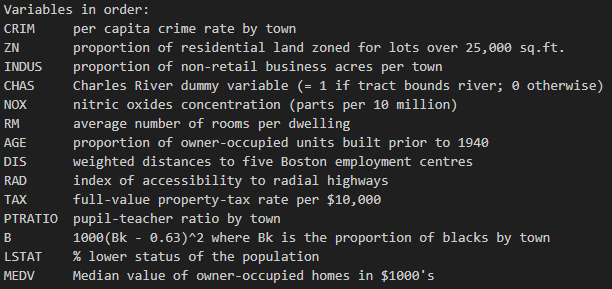

### Handle Null Value

In [177]:
boston.isnull().sum()

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64

In [178]:
# Fill missing values as specified
boston['CRIM'] = boston['CRIM'].fillna(boston['CRIM'].mean())
boston['ZN'] = boston['ZN'].fillna(boston['ZN'].mean())
boston['INDUS'] = boston['INDUS'].fillna(boston['INDUS'].mean())
boston['CHAS'] = boston['CHAS'].fillna(boston['CHAS'].mode()[0])
boston['AGE'] = boston['AGE'].fillna(boston['AGE'].mean())
boston['LSTAT'] = boston['LSTAT'].fillna(boston['LSTAT'].mean())

In [179]:
boston.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

### Check for Duplicate

In [180]:
duplicates =  boston[boston.duplicated(keep='first')]
duplicates

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV


No Duplicate Data

### Add MEDV_Class for Classification Problem

In [181]:
# Calculate percentiles for MEDV
low_threshold = boston['MEDV'].quantile(0.25)
high_threshold = boston['MEDV'].quantile(0.75)

def classify_medv(value):
    if value <= low_threshold:
        return 'Low'
    elif value <= high_threshold:
        return 'Medium'
    else:
        return 'High'

boston['MEDV_Class'] = boston['MEDV'].apply(classify_medv)

boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,MEDV_Class
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.980000,24.0,Medium
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.140000,21.6,Medium
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.030000,34.7,High
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.940000,33.4,High
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,12.715432,36.2,High


## Data Visualization

### Visualize with Graph

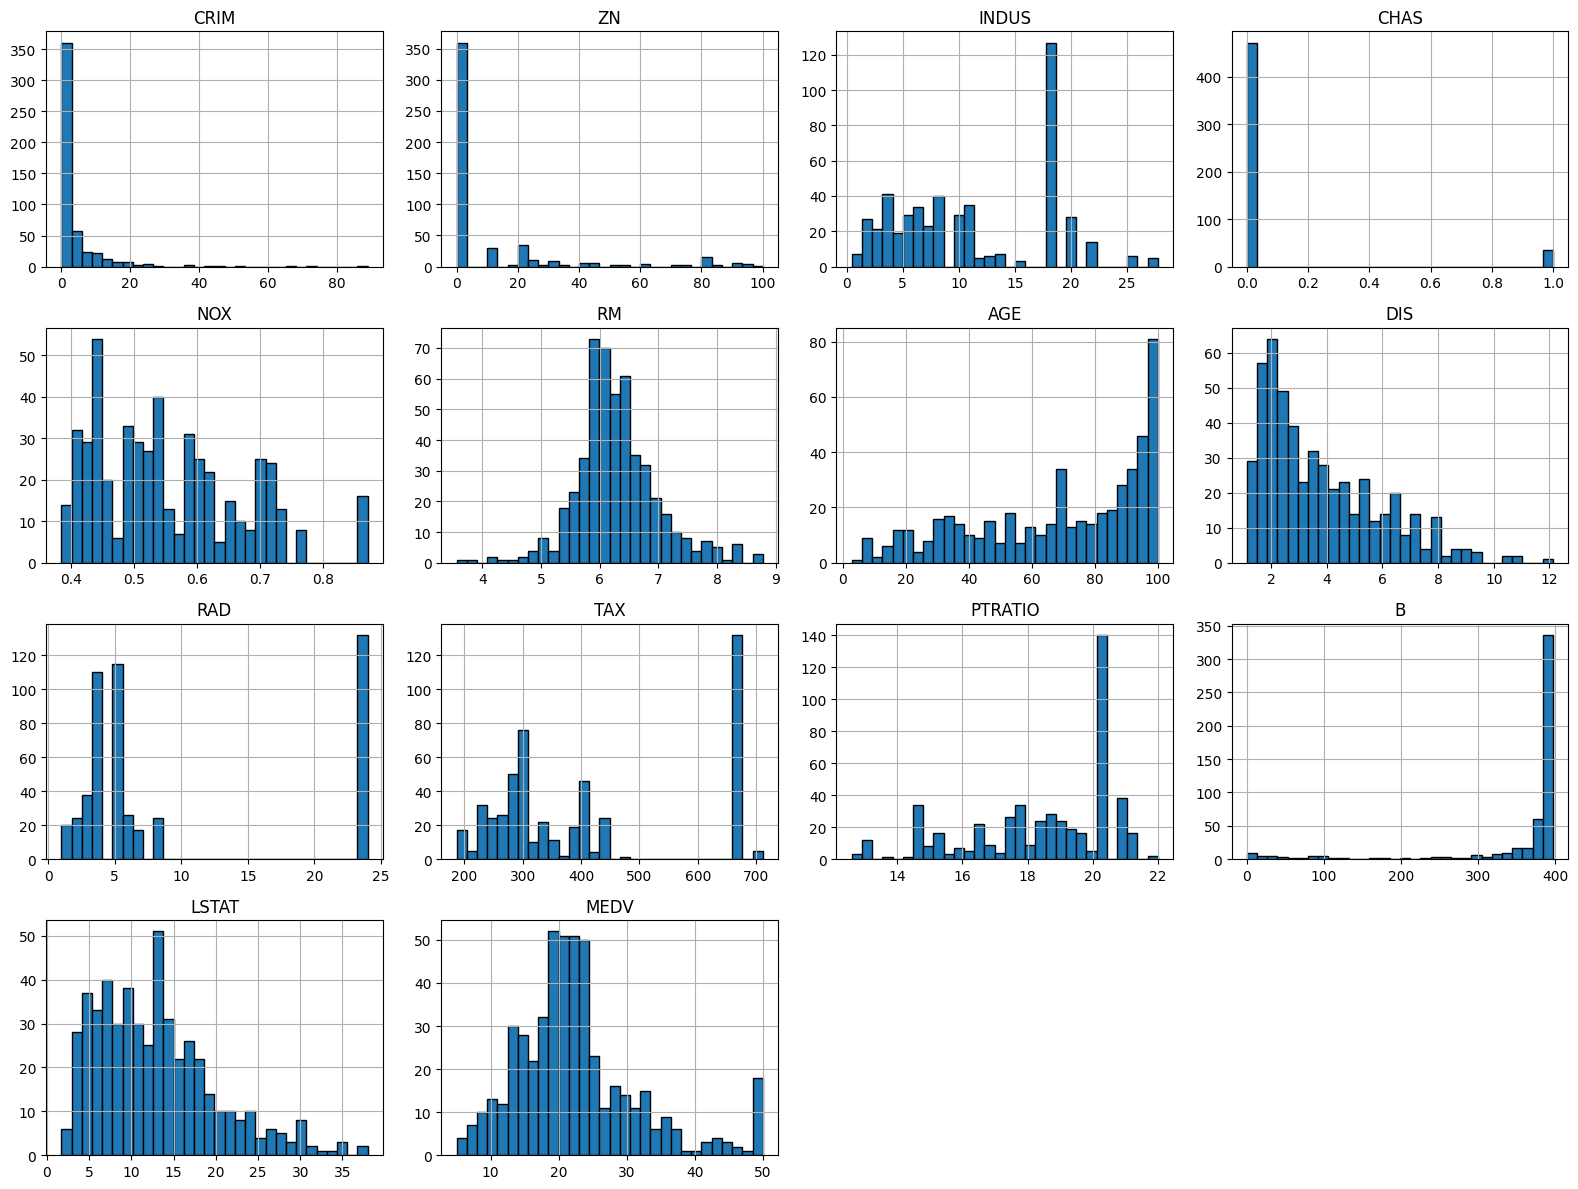

In [182]:
boston.hist(figsize=(16, 12), bins=30, edgecolor='black')
plt.tight_layout()
plt.show()

array([[<Axes: xlabel='CRIM', ylabel='CRIM'>,
        <Axes: xlabel='ZN', ylabel='CRIM'>,
        <Axes: xlabel='INDUS', ylabel='CRIM'>,
        <Axes: xlabel='CHAS', ylabel='CRIM'>,
        <Axes: xlabel='NOX', ylabel='CRIM'>,
        <Axes: xlabel='RM', ylabel='CRIM'>,
        <Axes: xlabel='AGE', ylabel='CRIM'>,
        <Axes: xlabel='DIS', ylabel='CRIM'>,
        <Axes: xlabel='RAD', ylabel='CRIM'>,
        <Axes: xlabel='TAX', ylabel='CRIM'>,
        <Axes: xlabel='PTRATIO', ylabel='CRIM'>,
        <Axes: xlabel='B', ylabel='CRIM'>,
        <Axes: xlabel='LSTAT', ylabel='CRIM'>,
        <Axes: xlabel='MEDV', ylabel='CRIM'>],
       [<Axes: xlabel='CRIM', ylabel='ZN'>,
        <Axes: xlabel='ZN', ylabel='ZN'>,
        <Axes: xlabel='INDUS', ylabel='ZN'>,
        <Axes: xlabel='CHAS', ylabel='ZN'>,
        <Axes: xlabel='NOX', ylabel='ZN'>,
        <Axes: xlabel='RM', ylabel='ZN'>,
        <Axes: xlabel='AGE', ylabel='ZN'>,
        <Axes: xlabel='DIS', ylabel='ZN'>,
        <Axes: x

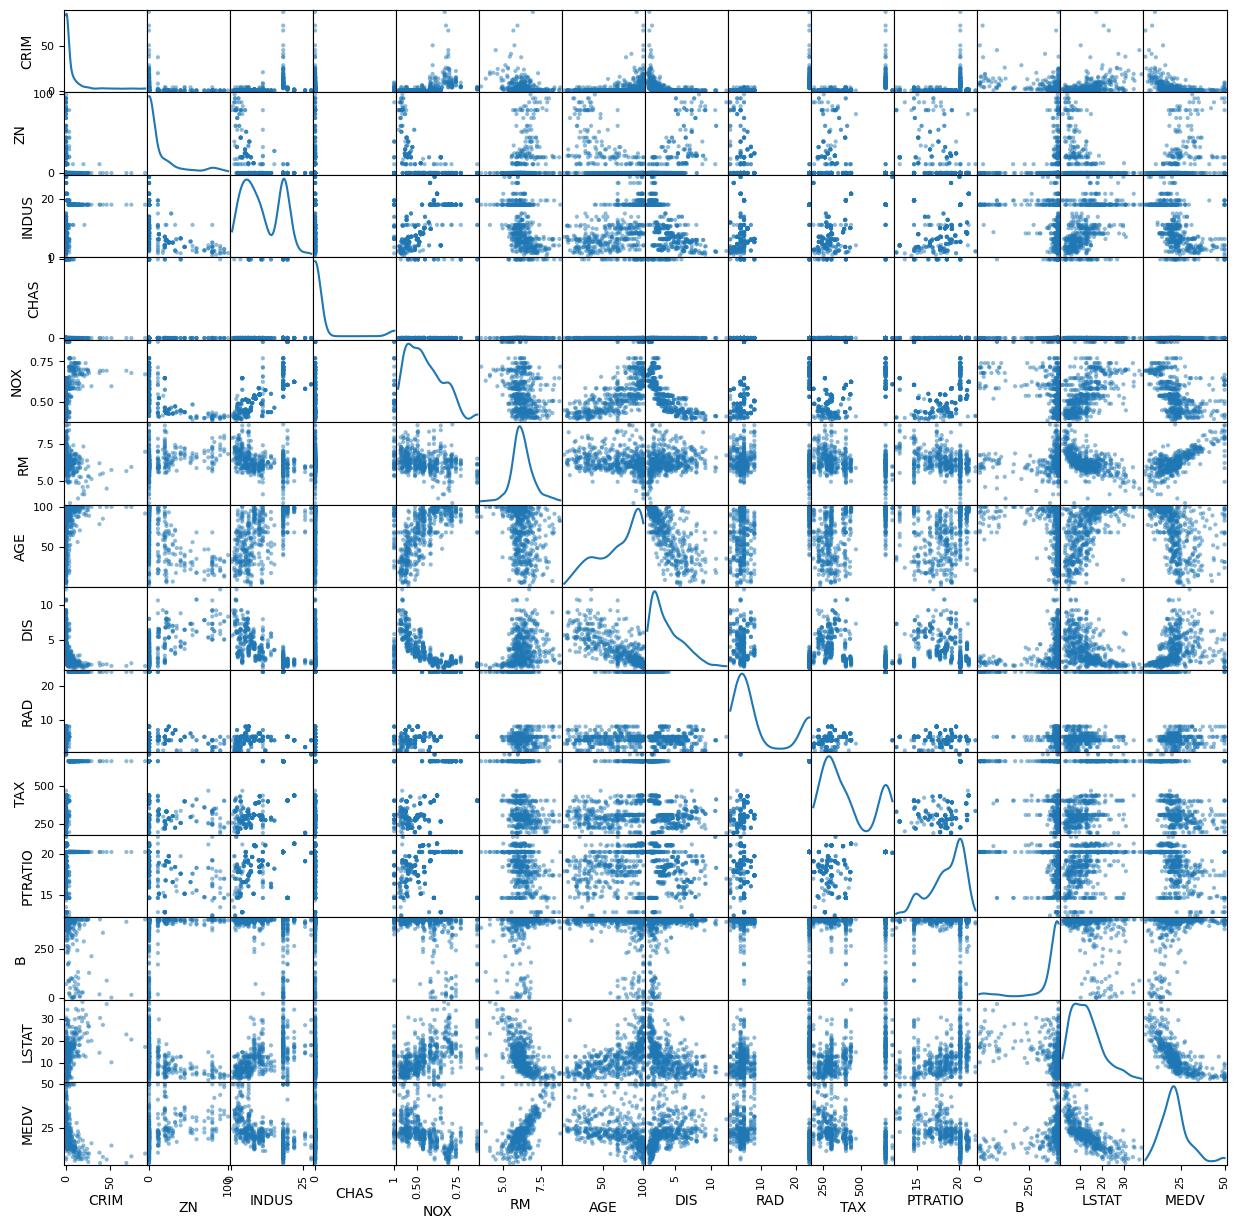

In [183]:
pd.plotting.scatter_matrix(boston, figsize=(15, 15), diagonal='kde')

### Heatmap of the Correlation

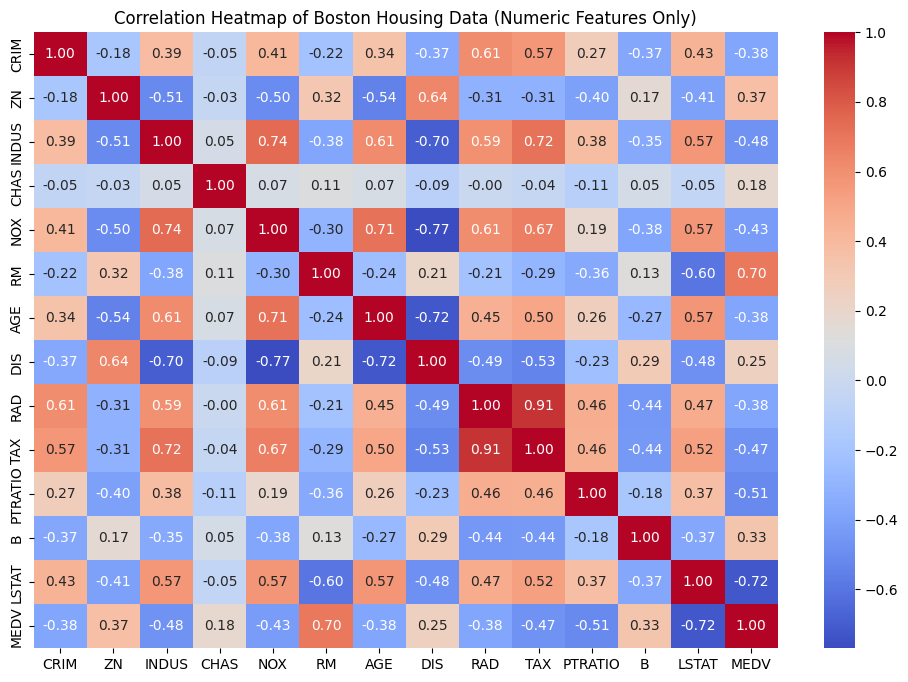

In [184]:
plt.figure(figsize=(12, 8))
corr = boston.select_dtypes(include=[float, int]).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Boston Housing Data (Numeric Features Only)')
plt.show()

In [185]:
numeric_cols = boston.select_dtypes(include=[float, int]).columns
correlations = boston[numeric_cols].corr()['MEDV'].sort_values(ascending=False)
print(correlations)

MEDV       1.000000
RM         0.695360
ZN         0.365943
B          0.333461
DIS        0.249929
CHAS       0.183844
CRIM      -0.379695
AGE       -0.380223
RAD       -0.381626
NOX       -0.427321
TAX       -0.468536
INDUS     -0.478657
PTRATIO   -0.507787
LSTAT     -0.721975
Name: MEDV, dtype: float64


### Scatter Plot for the most impact Features

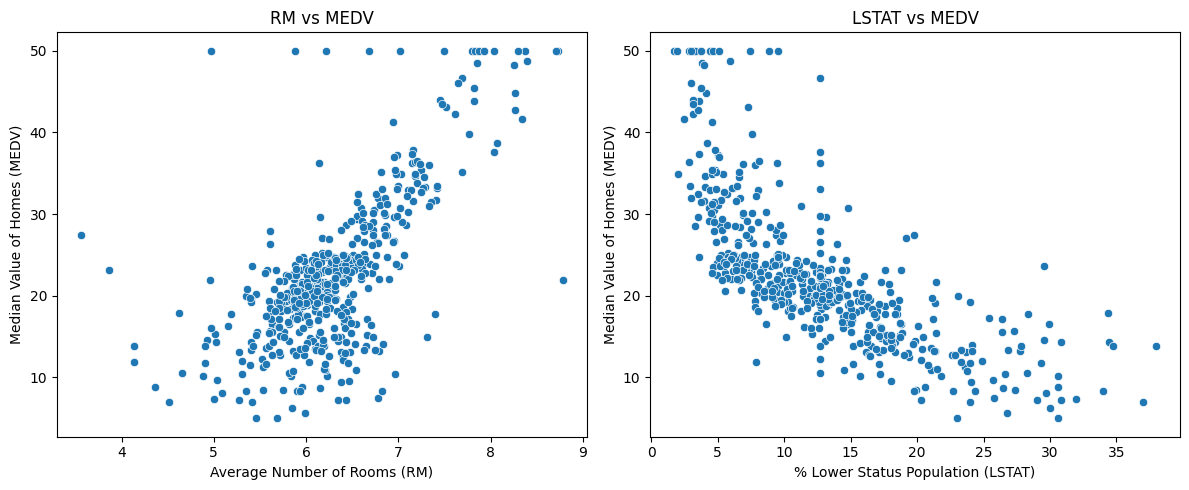

In [186]:
plt.figure(figsize=(12, 5))

# RM vs MEDV
plt.subplot(1, 2, 1)
sns.scatterplot(x='RM', y='MEDV', data=boston)
plt.title('RM vs MEDV')
plt.xlabel('Average Number of Rooms (RM)')
plt.ylabel('Median Value of Homes (MEDV)')

# LSTAT vs MEDV
plt.subplot(1, 2, 2)
sns.scatterplot(x='LSTAT', y='MEDV', data=boston)
plt.title('LSTAT vs MEDV')
plt.xlabel('% Lower Status Population (LSTAT)')
plt.ylabel('Median Value of Homes (MEDV)')

plt.tight_layout()
plt.show()

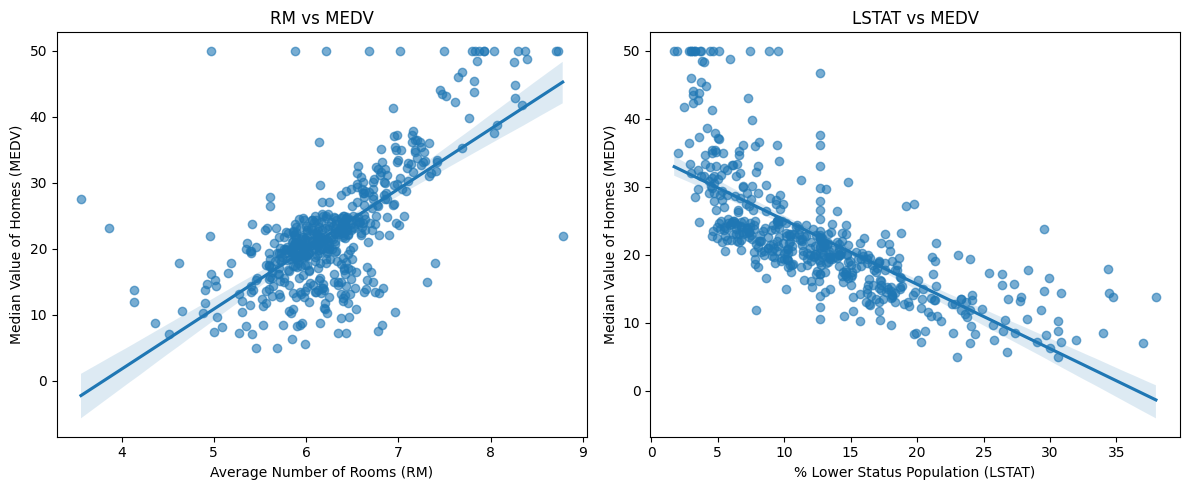

In [187]:
plt.figure(figsize=(12, 5))

# RM vs MEDV with regression line
plt.subplot(1, 2, 1)
sns.regplot(x='RM', y='MEDV', data=boston, scatter_kws={'alpha':0.6})
plt.title('RM vs MEDV')
plt.xlabel('Average Number of Rooms (RM)')
plt.ylabel('Median Value of Homes (MEDV)')

# LSTAT vs MEDV with regression line
plt.subplot(1, 2, 2)
sns.regplot(x='LSTAT', y='MEDV', data=boston, scatter_kws={'alpha':0.6})
plt.title('LSTAT vs MEDV')
plt.xlabel('% Lower Status Population (LSTAT)')
plt.ylabel('Median Value of Homes (MEDV)')

plt.tight_layout()
plt.show()

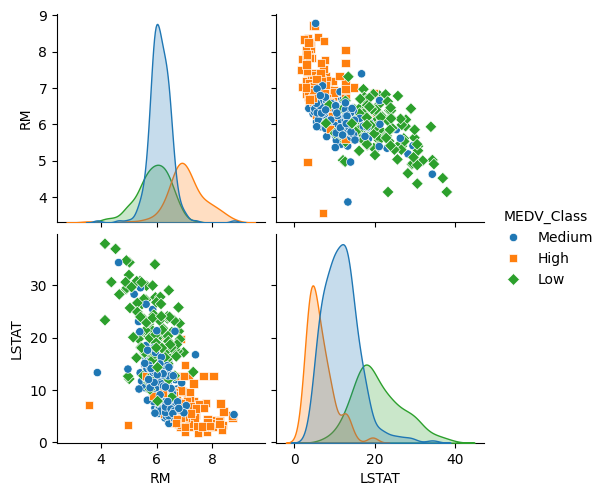

In [188]:
sns.pairplot(
    boston,
    vars=["RM", "LSTAT"],
    hue="MEDV_Class",
    markers=["o", "s", "D"]
)

## Training Regression Model

### Data Split

In [22]:
# Stratified split based on MEDV_Class
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
for train_idx, test_idx in sss.split(boston, boston['MEDV_Class']):
    boston_train = boston.iloc[train_idx]
    boston_test = boston.iloc[test_idx]

In [23]:
# Show the count of each unique class in MEDV_Class
class_counts = boston['MEDV_Class'].value_counts().reset_index()
class_counts.columns = ['MEDV_Class', 'Count']

print("Distribution of data based on MEDV_Class:")
print(class_counts)

Distribution of data based on MEDV_Class:
  MEDV_Class  Count
0     Medium    255
1        Low    127
2       High    124


In [24]:
print("Distribution of MEDV_Class in Training Set:")
print(boston_train['MEDV_Class'].value_counts())

print("\nDistribution of MEDV_Class in Test Set:")
print(boston_test['MEDV_Class'].value_counts())

Distribution of MEDV_Class in Training Set:
MEDV_Class
Medium    204
Low       101
High       99
Name: count, dtype: int64

Distribution of MEDV_Class in Test Set:
MEDV_Class
Medium    51
Low       26
High      25
Name: count, dtype: int64


In [25]:
X_train = boston_train.drop(columns=['MEDV', 'MEDV_Class'])
y_train = boston_train['MEDV']

In [26]:
X_test = boston_test.drop(columns=['MEDV', 'MEDV_Class'])
y_test = boston_test['MEDV']

In [27]:
print("X_train: ", len(X_train))
print("y_train: ", len(y_train))
print("\nX_test: ", len(X_test))
print("y_test: ", len(y_test))

X_train:  404
y_train:  404

X_test:  102
y_test:  102


### Data Scaling

In [128]:
scaler = scaler_selection()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [129]:
X_train

array([[5.78374450e-04, 0.00000000e+00, 4.92302053e-01, ...,
        4.04255319e-01, 9.89661607e-01, 3.21497920e-01],
       [1.32175642e-01, 0.00000000e+00, 6.46627566e-01, ...,
        8.08510638e-01, 9.51661708e-01, 4.34951456e-01],
       [9.78966488e-02, 0.00000000e+00, 6.46627566e-01, ...,
        8.08510638e-01, 1.00000000e+00, 3.34812760e-01],
       ...,
       [2.24458760e-03, 0.00000000e+00, 3.79398827e-01, ...,
        7.02127660e-01, 9.49669676e-01, 2.20804438e-01],
       [8.37145481e-02, 0.00000000e+00, 6.46627566e-01, ...,
        8.08510638e-01, 9.89359020e-01, 3.62274619e-01],
       [1.24730396e-03, 0.00000000e+00, 7.33137830e-02, ...,
        5.53191489e-01, 9.92990065e-01, 8.04438280e-02]], shape=(404, 13))

In [130]:
X_test

array([[1.45922195e-01, 0.00000000e+00, 6.46627566e-01, ...,
        8.08510638e-01, 8.51883605e-01, 7.78085992e-01],
       [8.01596361e-04, 0.00000000e+00, 4.20454545e-01, ...,
        8.93617021e-01, 1.00000000e+00, 1.03190014e-01],
       [1.39800820e-02, 0.00000000e+00, 2.81524927e-01, ...,
        8.93617021e-01, 7.71748449e-01, 4.26074896e-01],
       ...,
       [1.83387990e-02, 0.00000000e+00, 2.81524927e-01, ...,
        8.93617021e-01, 9.48736699e-01, 5.29819695e-01],
       [1.20651737e-03, 0.00000000e+00, 3.79398827e-01, ...,
        7.02127660e-01, 9.66791064e-01, 1.33148405e-01],
       [5.34319044e-03, 0.00000000e+00, 3.46041056e-01, ...,
        6.17021277e-01, 9.96948913e-01, 2.04160888e-01]], shape=(102, 13))

### Training The Model

#### Linear Regression

In [31]:
LR = LinearRegression()
LR

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [ ]:
%%time
LR.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [33]:
y_pred = LR.predict(X_test)
y_pred

array([11.79313985, 27.26714293, 14.81463407, 21.45696073, 15.24564389,
       20.5140206 , 27.77453834, 29.67506015, 36.13615564, 22.84406559,
       32.58635833, 14.09855017, 19.64482157, 29.23500732, 25.13566744,
       18.75554935, 25.63014908,  8.7752387 , 19.52122296, 23.92570598,
       14.9507333 ,  2.1385725 ,  6.902059  , 21.29432838, 29.88246075,
       11.83943753, 31.06260984, 25.52633063, 26.49644226, 22.12053797,
       25.97971787, 19.56387495, 17.66504541, 31.20265623, 28.55905891,
       27.30250226, 18.04048703, 37.86920121, 14.43117821, 31.06603537,
       36.22357813, 20.71908817, 31.0221969 , 24.24121587, 39.69067619,
       22.28067503, 20.34903899, 29.1614852 , 28.65516472, 20.49982567,
       13.45432102, 19.18786604, 22.45758667, 25.36926693, 34.17616286,
       24.91952816, 34.51452971, 20.26082669, 18.57345745, 19.23160543,
       28.77872558, 13.92097015, 13.49734959, 23.32820338, 17.18938356,
       27.98449054, 24.95990996, 17.13258627, 22.81595001, 12.56

In [34]:
y_test

399     6.3
503    23.9
27     14.8
119    19.3
492    20.1
       ... 
156    13.1
4      36.2
20     13.6
70     24.2
314    23.8
Name: MEDV, Length: 102, dtype: float64

In [35]:
MSE_LR = mean_squared_error(y_test, y_pred)
MAE_LR = mean_absolute_error(y_test, y_pred)
R2_LR = r2_score(y_test, y_pred)
RMSE_LR = math.sqrt(MSE_LR)

# Save model if better
save_model_if_better_regression(
    model_name="Linear Regression",
    model=LR,
    scaler=scaler,
    mse=MSE_LR,
    mae=MAE_LR,
    rmse=RMSE_LR,
    r2=R2_LR,
    parameters=LR.get_params()
)

Linear Regression: Better performance - updating model
   MSE: 100.5646 → 20.7810 (↓)
   R2:  0.1000 → 0.7248 (↑)
    Deleted old model: saved_models_regression\linear_regression_20250709_211405.pkl
    Deleted old scaler: saved_models_regression\linear_regression_scaler_20250709_211405.pkl
    New model saved to: saved_models_regression\linear_regression_20250709_233839.pkl
    New scaler saved to: saved_models_regression\linear_regression_scaler_20250709_233839.pkl


True

In [36]:
print("MSE_LR:", MSE_LR)
print("MAE_LR:", MAE_LR)
print("R2_LR:", R2_LR)
print("RMSE_LR:", RMSE_LR)

MSE_LR: 20.78103496813959
MAE_LR: 3.446395971388114
R2_LR: 0.7247912810542856
RMSE_LR: 4.558622047081727


#### Decision Tree Regressor

In [37]:
DTR = DecisionTreeRegressor()
DTR

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [ ]:
%%time
DTR.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [39]:
y_pred = DTR.predict(X_test)
y_pred

array([12.1, 23.6, 13.9, 16.1, 19.6, 18.2, 24.5, 23.7, 36. , 20.1, 37. ,
       12.7, 20.4, 23.9, 26.6, 14.2, 23.7, 14.4, 19.6, 19.1, 12.7, 11.9,
        7. , 20.4, 20.6,  9.6, 25. , 25. , 23.3, 18.2, 22. , 17.2, 14.2,
       23.7, 29.6, 21. ,  8.5, 46. , 17.8, 29. , 48.3, 15.2, 29. , 23.9,
       44.8, 20.7, 24.5, 21.8, 33. , 17.2, 11.3, 19.4, 11.9, 20.4, 33. ,
       24.4, 23.7, 19. , 17.2, 12.6, 23.3, 12.7, 13.3, 19.1, 12.7, 22.6,
       24. , 17.7, 22.9, 15. , 18.6, 14.3, 36.1, 43.5, 19.2, 43.5, 22.9,
       21.7, 19.4, 33.4, 18.5, 17.7, 29.6, 33.2, 23.3, 18.9, 37. , 28. ,
       23.7, 25. , 16.5,  7. , 22. , 50. , 27.5, 19. , 23.7, 15.6, 30.7,
       12.7, 22.6, 23.9])

In [40]:
y_test

399     6.3
503    23.9
27     14.8
119    19.3
492    20.1
       ... 
156    13.1
4      36.2
20     13.6
70     24.2
314    23.8
Name: MEDV, Length: 102, dtype: float64

In [ ]:
MSE_DTR = mean_squared_error(y_test, y_pred)
MAE_DTR = mean_absolute_error(y_test, y_pred)
R2_DTR = r2_score(y_test, y_pred)
RMSE_DTR = math.sqrt(MSE_DTR)

# Save model if better
save_model_if_better_regression(
    model_name="Decision Tree",
    model=DTR,
    scaler=scaler,
    mse=MSE_DTR,
    mae=MAE_DTR,
    rmse=RMSE_DTR,
    r2=R2_DTR,
    parameters=DTR.get_params()
)

Decision Tree: No improvement - keeping existing model
   Current MSE: 15.9664 vs Best: 14.8790
   Current R2:  0.7886 vs Best: 0.8030


False

In [42]:
print("MSE_DTR:", MSE_DTR)
print("MAE_DTR:", MAE_DTR)
print("R2_DTR:", R2_DTR)
print("RMSE_DTR:", RMSE_DTR)

MSE_DTR: 15.966372549019606
MAE_DTR: 2.922549019607843
R2_DTR: 0.7885531234530672
RMSE_DTR: 3.9957943576990553


#### Random Forest Regressor

In [43]:
RFR = RandomForestRegressor(random_state=42)
RFR

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
%%time
RFR.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [45]:
y_pred = RFR.predict(X_test)
y_pred

array([ 9.684, 26.653, 15.434, 20.455, 20.289, 19.918, 25.745, 24.944,
       33.796, 20.916, 30.994, 15.619, 20.179, 23.436, 27.035, 15.017,
       24.143, 14.355, 20.367, 20.904, 17.498, 13.845,  7.757, 19.586,
       22.417, 10.396, 24.626, 23.436, 24.548, 18.473, 24.823, 13.873,
       14.439, 25.203, 30.718, 21.402, 13.952, 41.534, 11.714, 25.953,
       43.242, 15.905, 29.569, 25.876, 43.502, 23.707, 20.334, 20.998,
       35.318, 12.821, 10.771, 20.633, 18.892, 20.564, 32.982, 22.881,
       27.185, 17.878, 11.087, 14.363, 24.974, 14.567, 14.975, 20.616,
       14.673, 22.445, 21.466, 17.932, 21.094, 18.462, 20.793, 15.815,
       33.726, 44.261, 21.363, 45.328, 22.577, 20.852, 18.389, 30.912,
       19.854, 17.171, 32.601, 30.477, 20.407, 17.59 , 33.998, 25.163,
       26.676, 22.705, 21.166,  8.093, 22.08 , 48.813, 20.657, 16.946,
       24.341, 16.3  , 30.779, 15.186, 23.88 , 24.141])

In [46]:
y_test

399     6.3
503    23.9
27     14.8
119    19.3
492    20.1
       ... 
156    13.1
4      36.2
20     13.6
70     24.2
314    23.8
Name: MEDV, Length: 102, dtype: float64

In [ ]:
MSE_RFR = mean_squared_error(y_test, y_pred)
MAE_RFR = mean_absolute_error(y_test, y_pred)
R2_RFR = r2_score(y_test, y_pred)
RMSE_RFR = math.sqrt(MSE_RFR)

# Save model if better
save_model_if_better_regression(
    model_name="Random Forest",
    model=RFR,
    scaler=scaler,
    mse=MSE_RFR,
    mae=MAE_RFR,
    rmse=RMSE_RFR,
    r2=R2_RFR,
    parameters=RFR.get_params()
)

Random Forest: No improvement - keeping existing model
   Current MSE: 8.8477 vs Best: 8.8477
   Current R2:  0.8828 vs Best: 0.8828


False

In [48]:
print("MSE_RFR:", MSE_RFR)
print("MAE_RFR:", MAE_RFR)
print("R2_RFR:", R2_RFR)
print("RMSE_RFR:", RMSE_RFR)

MSE_RFR: 8.847735019607846
MAE_RFR: 2.158901960784313
R2_RFR: 0.8828271150089211
RMSE_RFR: 2.9745142493536396


#### Support Vector Machine

In [49]:
SVR_model = SVR()
SVR_model

,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,1.0
,epsilon,0.1
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [ ]:
%%time
SVR_model.fit(X_train, y_train)

,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,1.0
,epsilon,0.1
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [51]:
y_pred = SVR_model.predict(X_test)
y_pred

array([12.08244339, 23.75752359, 16.6960407 , 20.12342863, 17.69689395,
       20.07045635, 25.40832208, 28.07281723, 31.06890592, 18.83619158,
       26.41423461, 16.01640956, 20.26583117, 25.33520055, 20.20137103,
       15.77151402, 26.36892457, 15.78758786, 20.17844203, 21.60313676,
       15.86477238, 10.86047302, 10.11291995, 19.08019547, 24.92110371,
       11.77277826, 27.48114616, 23.84898485, 24.5197621 , 24.97420932,
       23.09837933, 15.46180478, 14.67626636, 28.26981791, 27.27842365,
       24.5146369 , 14.90278337, 31.35218914, 12.85522399, 25.92736074,
       28.39455017, 16.42858765, 28.95047197, 24.59500107, 31.89974916,
       19.18623034, 21.20836339, 26.98192316, 26.75305396, 15.11034729,
       13.30049146, 19.91215109, 23.50170882, 22.29576767, 28.64668551,
       23.87214973, 29.9438854 , 17.56893103, 14.40065271, 15.5504453 ,
       25.53587559, 15.98818885, 15.25958204, 21.22844535, 14.54535724,
       25.29217698, 22.6453028 , 18.00021989, 20.5091249 , 16.94

In [52]:
y_test

399     6.3
503    23.9
27     14.8
119    19.3
492    20.1
       ... 
156    13.1
4      36.2
20     13.6
70     24.2
314    23.8
Name: MEDV, Length: 102, dtype: float64

In [53]:
MSE_SVR = mean_squared_error(y_test, y_pred)
MAE_SVR = mean_absolute_error(y_test, y_pred)
R2_SVR = r2_score(y_test, y_pred)
RMSE_SVR = math.sqrt(MSE_SVR)

# Save model if better
save_model_if_better_regression(
    model_name="SVR",
    model=SVR_model,
    scaler=scaler,
    mse=MSE_SVR,
    mae=MAE_SVR,
    rmse=RMSE_SVR,
    r2=R2_SVR,
    parameters=SVR_model.get_params()
)

SVR: No improvement - keeping existing model
   Current MSE: 26.0729 vs Best: 26.0729
   Current R2:  0.6547 vs Best: 0.6547


False

In [54]:
print("MSE_SVR:", MSE_SVR)
print("MAE_SVR:", MAE_SVR)
print("R2_SVR:", R2_SVR)
print("RMSE_SVR:", RMSE_SVR)

MSE_SVR: 26.072942842511814
MAE_SVR: 3.264461993420453
R2_SVR: 0.6547091514049411
RMSE_SVR: 5.106167138129324


### Grid Search CV - Hyperparameters Tuning

#### Tuning Linear Regressor

In [55]:
linear_param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False]
}

In [56]:
linear_grid_search = GridSearchCV(
    LinearRegression(), 
    linear_param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1,
    verbose=1
)

In [ ]:
%%time
print("Starting hyperparameter tuning for Linear Regression...")
linear_grid_search.fit(X_train, y_train)

Starting hyperparameter tuning for Linear Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


,estimator,LinearRegression()
,param_grid,"{'copy_X': [True, False], 'fit_intercept': [True, False], 'positive': [True, False]}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,fit_intercept,True


In [58]:
print("LINEAR REGRESSION TUNING RESULTS")
print("="*50)
print("Best Parameters:", linear_grid_search.best_params_)
print("Best Cross-Validation Score (Negative MSE):", linear_grid_search.best_score_)
print("Best Cross-Validation Score (MSE):", -linear_grid_search.best_score_)
print("Best Cross-Validation Score (RMSE):", math.sqrt(-linear_grid_search.best_score_))

LINEAR REGRESSION TUNING RESULTS
Best Parameters: {'copy_X': True, 'fit_intercept': True, 'positive': False}
Best Cross-Validation Score (Negative MSE): -26.174795333860857
Best Cross-Validation Score (MSE): 26.174795333860857
Best Cross-Validation Score (RMSE): 5.116130894910807


In [59]:
GSCV_LR_Model = linear_grid_search.best_estimator_
y_pred = GSCV_LR_Model.predict(X_test)

In [60]:
MSE_GSCV_LR = mean_squared_error(y_test, y_pred)
MAE_GSCV_LR = mean_absolute_error(y_test, y_pred)
R2_GSCV_LR = r2_score(y_test, y_pred)
RMSE_GSCV_LR = math.sqrt(MSE_GSCV_LR)

# Save model if better
save_model_if_better_regression(
    model_name="Linear Regression Tuned (GSCV)",
    model=GSCV_LR_Model,
    scaler=scaler,
    mse=MSE_GSCV_LR,
    mae=MAE_GSCV_LR,
    rmse=RMSE_GSCV_LR,
    r2=R2_GSCV_LR,
    parameters={
        "best_params": linear_grid_search.best_params_,
        "cv_score": linear_grid_search.best_score_,
        "all_params": GSCV_LR_Model.get_params()
    }
)

Linear Regression Tuned (GSCV): First time training - saving model
    New model saved to: saved_models_regression\linear_regression_tuned_(gscv)_20250709_233844.pkl
    New scaler saved to: saved_models_regression\linear_regression_tuned_(gscv)_scaler_20250709_233844.pkl


True

In [61]:
print("MSE_GSCV_LR:", MSE_GSCV_LR)
print("MAE_GSCV_LR:", MAE_GSCV_LR)
print("R2_GSCV_LR:", R2_GSCV_LR)
print("RMSE_GSCV_LR:", RMSE_GSCV_LR)

MSE_GSCV_LR: 20.78103496813959
MAE_GSCV_LR: 3.446395971388114
R2_GSCV_LR: 0.7247912810542856
RMSE_GSCV_LR: 4.558622047081727


#### Tuning Decision Tree Regressor

In [62]:
decision_tree_param_grid = {
    'max_depth': [None, 5, 10, 15, 25],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None, 0.5],
    'criterion': ['squared_error', 'friedman_mse'],
    'min_impurity_decrease': [0.0, 0.01, 0.02],
    'ccp_alpha': [0.0, 0.01, 0.02]
}

In [63]:
decision_tree_grid_search = GridSearchCV(
    DecisionTreeRegressor(random_state=42), 
    decision_tree_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

In [ ]:
%%time
print("Starting hyperparameter tuning for Decision Tree Regressor...")
decision_tree_grid_search.fit(X_train, y_train)

Starting hyperparameter tuning for Decision Tree Regressor...
Fitting 5 folds for each of 5760 candidates, totalling 28800 fits


,estimator,DecisionTreeR...ndom_state=42)
,param_grid,"{'ccp_alpha': [0.0, 0.01, ...], 'criterion': ['squared_error', 'friedman_mse'], 'max_depth': [None, 5, ...], 'max_features': ['sqrt', 'log2', ...], ...}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'squared_error'


In [65]:
print("DECISION TREE TUNING RESULTS")
print("="*50)
print("Best Parameters:", decision_tree_grid_search.best_params_)
print("Best Cross-Validation Score (Negative MSE):", decision_tree_grid_search.best_score_)
print("Best Cross-Validation Score (MSE):", -decision_tree_grid_search.best_score_)
print("Best Cross-Validation Score (RMSE):", math.sqrt(-decision_tree_grid_search.best_score_))

DECISION TREE TUNING RESULTS
Best Parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 8, 'min_samples_split': 2}
Best Cross-Validation Score (Negative MSE): -21.54953892839407
Best Cross-Validation Score (MSE): 21.54953892839407
Best Cross-Validation Score (RMSE): 4.642148094190239


In [66]:
GSCV_DTR_Model = decision_tree_grid_search.best_estimator_
y_pred = GSCV_DTR_Model.predict(X_test)

In [67]:
MSE_GSCV_DTR = mean_squared_error(y_test, y_pred)
MAE_GSCV_DTR = mean_absolute_error(y_test, y_pred)
R2_GSCV_DTR = r2_score(y_test, y_pred)
RMSE_GSCV_DTR = math.sqrt(MSE_GSCV_DTR)

# Save model if better
save_model_if_better_regression(
    model_name="Decision Tree Tuned (GSCV)",
    model=GSCV_DTR_Model,
    scaler=scaler,
    mse=MSE_GSCV_DTR,
    mae=MAE_GSCV_DTR,
    rmse=RMSE_GSCV_DTR,
    r2=R2_GSCV_DTR,
    parameters={
        "best_params": decision_tree_grid_search.best_params_,
        "cv_score": decision_tree_grid_search.best_score_,
        "all_params": GSCV_DTR_Model.get_params()
    }
)

Decision Tree Tuned (GSCV): First time training - saving model
    New model saved to: saved_models_regression\decision_tree_tuned_(gscv)_20250709_233903.pkl
    New scaler saved to: saved_models_regression\decision_tree_tuned_(gscv)_scaler_20250709_233903.pkl


True

In [68]:
print("MSE_GSCV_DTR:", MSE_GSCV_DTR)
print("MAE_GSCV_DTR:", MAE_GSCV_DTR)
print("R2_GSCV_DTR:", R2_GSCV_DTR)
print("RMSE_GSCV_DTR:", RMSE_GSCV_DTR)

MSE_GSCV_DTR: 17.15274552968538
MAE_GSCV_DTR: 3.1398365087936955
R2_GSCV_DTR: 0.7728416736286763
RMSE_GSCV_DTR: 4.141587320060435


#### Tuning Support Vector Machine

In [69]:
svr_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'epsilon': [0.01, 0.1, 0.2],
    'degree': [2, 3, 4, 5],
    'coef0': [0.0, 0.1, 1.0],
    'shrinking': [True, False],
    'tol': [1e-3, 1e-4]
}

In [70]:
svr_grid_search = GridSearchCV(
    SVR(), 
    svr_param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1,
    verbose=1
)

In [ ]:
%%time
print("Starting hyperparameter tuning for SVR...")
svr_grid_search.fit(X_train, y_train)

Starting hyperparameter tuning for SVR...
Fitting 5 folds for each of 11520 candidates, totalling 57600 fits


,estimator,SVR()
,param_grid,"{'C': [0.1, 1, ...], 'coef0': [0.0, 0.1, ...], 'degree': [2, 3, ...], 'epsilon': [0.01, 0.1, ...], ...}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,kernel,'rbf'


In [72]:
print("SVR TUNING RESULTS")
print("="*50)
print("Best Parameters:", svr_grid_search.best_params_)
print("Best Cross-Validation Score (Negative MSE):", svr_grid_search.best_score_)
print("Best Cross-Validation Score (MSE):", -svr_grid_search.best_score_)
print("Best Cross-Validation Score (RMSE):", math.sqrt(-svr_grid_search.best_score_))

SVR TUNING RESULTS
Best Parameters: {'C': 100, 'coef0': 0.0, 'degree': 2, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': False, 'tol': 0.001}
Best Cross-Validation Score (Negative MSE): -13.79203232392696
Best Cross-Validation Score (MSE): 13.79203232392696
Best Cross-Validation Score (RMSE): 3.713762556212629


In [73]:
GSCV_SVR_Model = svr_grid_search.best_estimator_
y_pred_svr = GSCV_SVR_Model.predict(X_test)

In [74]:
MSE_GSCV_SVR = mean_squared_error(y_test, y_pred_svr)
MAE_GSCV_SVR = mean_absolute_error(y_test, y_pred_svr)
R2_GSCV_SVR = r2_score(y_test, y_pred_svr)
RMSE_GSCV_SVR = math.sqrt(MSE_GSCV_SVR)

# Save model if better
save_model_if_better_regression(
    model_name="SVR Tuned (GSCV)",
    model=GSCV_SVR_Model,
    scaler=scaler,
    mse=MSE_GSCV_SVR,
    mae=MAE_GSCV_SVR,
    rmse=RMSE_GSCV_SVR,
    r2=R2_GSCV_SVR,
    parameters={
        "best_params": svr_grid_search.best_params_,
        "cv_score": svr_grid_search.best_score_,
        "all_params": GSCV_SVR_Model.get_params()
    }
)

SVR Tuned (GSCV): First time training - saving model
    New model saved to: saved_models_regression\svr_tuned_(gscv)_20250709_234608.pkl
    New scaler saved to: saved_models_regression\svr_tuned_(gscv)_scaler_20250709_234608.pkl


True

In [75]:
print("MSE_GSCV_SVR:", MSE_GSCV_SVR)
print("MAE_GSCV_SVR:", MAE_GSCV_SVR)
print("R2_GSCV_SVR:", R2_GSCV_SVR)
print("RMSE_GSCV_SVR:", RMSE_GSCV_SVR)

MSE_GSCV_SVR: 7.597422413458519
MAE_GSCV_SVR: 1.998276996733651
R2_GSCV_SVR: 0.8993853341326358
RMSE_GSCV_SVR: 2.7563422163183073


#### Tuning Random Forest Regressor

In [ ]:
# For bootstrap=True cases
bootstrap_true_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True],
    'max_samples': [None, 0.8, 0.9],
    'min_impurity_decrease': [0.0, 0.01, 0.02]
}

# For bootstrap=False cases  
bootstrap_false_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [False],
    'min_impurity_decrease': [0.0, 0.01, 0.02]
}

random_forest_param_grid = [bootstrap_true_params, bootstrap_false_params]

In [ ]:
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42), 
    random_forest_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

In [ ]:
%%time
print("Starting hyperparameter tuning for Random Forest...")
grid_search.fit(X_train, y_train)

Starting hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 12960 candidates, totalling 64800 fits


c:\Users\joyde\Documents\GitHub\BostonML\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
21600 fits failed out of a total of 64800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21600 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joyde\Documents\GitHub\BostonML\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\joyde\Documents\GitHub\BostonML\.venv\Lib\site-packages\sklearn\base.py", line 1363, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\joyde\Documents\GitHub\Bost

,estimator,RandomForestR...ndom_state=42)
,param_grid,"{'bootstrap': [True, False], 'max_depth': [None, 10, ...], 'max_features': ['sqrt', 'log2', ...], 'max_samples': [None, 0.8, ...], ...}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [79]:
print("HYPERPARAMETER TUNING RESULTS")
print("="*50)
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score (Negative MSE):", grid_search.best_score_)
print("Best Cross-Validation Score (MSE):", -grid_search.best_score_)
print("Best Cross-Validation Score (RMSE):", math.sqrt(-grid_search.best_score_))

HYPERPARAMETER TUNING RESULTS
Best Parameters: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Score (Negative MSE): -10.648515104237664
Best Cross-Validation Score (MSE): 10.648515104237664
Best Cross-Validation Score (RMSE): 3.263206261368972


In [80]:
GSCV_RFR_Model = grid_search.best_estimator_
y_pred = GSCV_RFR_Model.predict(X_test)

In [81]:
MSE_GSCV_RFR = mean_squared_error(y_test, y_pred)
MAE_GSCV_RFR = mean_absolute_error(y_test, y_pred)
R2_GSCV_RFR = r2_score(y_test, y_pred)
RMSE_GSCV_RFR = math.sqrt(MSE_GSCV_RFR)

# Save model if better
save_model_if_better_regression(
    model_name="Random Forest Tuned (GSCV)",
    model=GSCV_RFR_Model,
    scaler=scaler,
    mse=MSE_GSCV_RFR,
    mae=MAE_GSCV_RFR,
    rmse=RMSE_GSCV_RFR,
    r2=R2_GSCV_RFR,
    parameters={
        "best_params": grid_search.best_params_,
        "cv_score": grid_search.best_score_,
        "all_params": GSCV_RFR_Model.get_params()
    }
)

Random Forest Tuned (GSCV): First time training - saving model
    New model saved to: saved_models_regression\random_forest_tuned_(gscv)_20250710_004744.pkl
    New scaler saved to: saved_models_regression\random_forest_tuned_(gscv)_scaler_20250710_004744.pkl


True

In [82]:
print("MSE_GSCV_RFR:", MSE_GSCV_RFR)
print("MAE_GSCV_RFR:", MAE_GSCV_RFR)
print("R2_GSCV_RFR:", R2_GSCV_RFR)
print("RMSE_GSCV_RFR:", RMSE_GSCV_RFR)

MSE_GSCV_RFR: 7.0265858663822085
MAE_GSCV_RFR: 1.9441995803129926
R2_GSCV_RFR: 0.9069450728602363
RMSE_GSCV_RFR: 2.650770806083055


In [83]:
feature_names = boston.drop(columns=['MEDV', 'MEDV_Class']).columns

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': GSCV_RFR_Model.feature_importances_
}).sort_values('importance', ascending=False)

print("FEATURE IMPORTANCE (TOP 10)")
print("="*50)
print(feature_importance.head(10))

FEATURE IMPORTANCE (TOP 10)
    feature  importance
5        RM    0.280027
12    LSTAT    0.238473
4       NOX    0.081202
2     INDUS    0.078846
10  PTRATIO    0.065723
7       DIS    0.063773
0      CRIM    0.059544
9       TAX    0.040773
6       AGE    0.027436
11        B    0.024855


### Randomized Search CV - Hyperparameters Tuning

#### Tuning Linear Regressor

In [31]:
linear_param_dist = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False]
}

In [32]:
linear_random_search = RandomizedSearchCV(
    LinearRegression(), 
    linear_param_dist, 
    n_iter=8,
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [ ]:
%%time
print("Starting RANDOMIZED hyperparameter tuning for Linear Regression...")
linear_random_search.fit(X_train, y_train)

Starting RANDOMIZED hyperparameter tuning for Linear Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


,estimator,LinearRegression()
,param_distributions,"{'copy_X': [True, False], 'fit_intercept': [True, False], 'positive': [True, False]}"
,n_iter,8
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [34]:
print("LINEAR REGRESSION RANDOMIZED SEARCH RESULTS")
print("="*50)
print("Best Parameters:", linear_random_search.best_params_)
print("Best Cross-Validation Score (Negative MSE):", linear_random_search.best_score_)
print("Best Cross-Validation Score (MSE):", -linear_random_search.best_score_)
print("Best Cross-Validation Score (RMSE):", math.sqrt(-linear_random_search.best_score_))

LINEAR REGRESSION RANDOMIZED SEARCH RESULTS
Best Parameters: {'positive': False, 'fit_intercept': True, 'copy_X': True}
Best Cross-Validation Score (Negative MSE): -26.174795333860857
Best Cross-Validation Score (MSE): 26.174795333860857
Best Cross-Validation Score (RMSE): 5.116130894910807


In [35]:
RSCV_LR_Model = linear_random_search.best_estimator_
y_pred = RSCV_LR_Model.predict(X_test)

In [36]:
MSE_RSCV_LR = mean_squared_error(y_test, y_pred)
MAE_RSCV_LR = mean_absolute_error(y_test, y_pred)
R2_RSCV_LR = r2_score(y_test, y_pred)
RMSE_RSCV_LR = math.sqrt(MSE_RSCV_LR)

# Save model if better
save_model_if_better_regression(
    model_name="Linear Regression Tuned (RSCV)",
    model=RSCV_LR_Model,
    scaler=scaler,
    mse=MSE_RSCV_LR,
    mae=MAE_RSCV_LR,
    rmse=RMSE_RSCV_LR,
    r2=R2_RSCV_LR,
    parameters={
        "best_params": linear_random_search.best_params_,
        "cv_score": linear_random_search.best_score_,
        "all_params": RSCV_LR_Model.get_params()
    }
)

Linear Regression Tuned (RSCV): First time training - saving model
    New model saved to: saved_models_regression\linear_regression_tuned_(rscv)_20250710_014608.pkl
    New scaler saved to: saved_models_regression\linear_regression_tuned_(rscv)_scaler_20250710_014608.pkl


True

In [37]:
print("MSE_RSCV_LR:", MSE_RSCV_LR)
print("MAE_RSCV_LR:", MAE_RSCV_LR)
print("R2_RSCV_LR:", R2_RSCV_LR)
print("RMSE_RSCV_LR:", RMSE_RSCV_LR)

MSE_RSCV_LR: 20.78103496813959
MAE_RSCV_LR: 3.446395971388114
R2_RSCV_LR: 0.7247912810542856
RMSE_RSCV_LR: 4.558622047081727


#### Tuning Decision Tree Regressor

In [38]:
decision_tree_param_dist = {
    'max_depth': [None, 3, 5, 8, 10, 15, 20, 25, 30, 35],
    'min_samples_split': [2, 3, 5, 8, 10, 15, 20, 25, 30],
    'min_samples_leaf': [1, 2, 3, 4, 6, 8, 10, 12, 15],
    'max_features': ['sqrt', 'log2', None, 0.3, 0.5, 0.7, 0.8, 1.0],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'min_impurity_decrease': [0.0, 0.005, 0.01, 0.015, 0.02, 0.03, 0.05],
    'ccp_alpha': [0.0, 0.005, 0.01, 0.015, 0.02, 0.03, 0.05, 0.1],
    'splitter': ['best', 'random'],
    'max_leaf_nodes': [None, 10, 20, 30, 50, 100, 150, 200, 300],
    'min_weight_fraction_leaf': [0.0, 0.01, 0.02, 0.05, 0.1]
}

In [39]:
decision_tree_random_search = RandomizedSearchCV(
    DecisionTreeRegressor(random_state=42), 
    decision_tree_param_dist,
    n_iter=200,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [ ]:
%%time
print("Starting RANDOMIZED hyperparameter tuning for Decision Tree Regressor...")
decision_tree_random_search.fit(X_train, y_train)

Starting RANDOMIZED hyperparameter tuning for Decision Tree Regressor...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


,estimator,DecisionTreeR...ndom_state=42)
,param_distributions,"{'ccp_alpha': [0.0, 0.005, ...], 'criterion': ['squared_error', 'friedman_mse', ...], 'max_depth': [None, 3, ...], 'max_features': ['sqrt', 'log2', ...], ...}"
,n_iter,200
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [41]:
print("DECISION TREE RANDOMIZED SEARCH RESULTS")
print("="*50)
print("Best Parameters:", decision_tree_random_search.best_params_)
print("Best Cross-Validation Score (Negative MSE):", decision_tree_random_search.best_score_)
print("Best Cross-Validation Score (MSE):", -decision_tree_random_search.best_score_)
print("Best Cross-Validation Score (RMSE):", math.sqrt(-decision_tree_random_search.best_score_))

DECISION TREE RANDOMIZED SEARCH RESULTS
Best Parameters: {'splitter': 'best', 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 20, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.005, 'max_leaf_nodes': 30, 'max_features': 1.0, 'max_depth': 35, 'criterion': 'poisson', 'ccp_alpha': 0.015}
Best Cross-Validation Score (Negative MSE): -18.982497916703586
Best Cross-Validation Score (MSE): 18.982497916703586
Best Cross-Validation Score (RMSE): 4.3568908543482685


In [42]:
RSCV_DTR_Model = decision_tree_random_search.best_estimator_
y_pred = RSCV_DTR_Model.predict(X_test)

In [43]:
MSE_RSCV_DTR = mean_squared_error(y_test, y_pred)
MAE_RSCV_DTR = mean_absolute_error(y_test, y_pred)
R2_RSCV_DTR = r2_score(y_test, y_pred)
RMSE_RSCV_DTR = math.sqrt(MSE_RSCV_DTR)

# Save model if better
save_model_if_better_regression(
    model_name="Decision Tree Tuned (RSCV)",
    model=RSCV_DTR_Model,
    scaler=scaler,
    mse=MSE_RSCV_DTR,
    mae=MAE_RSCV_DTR,
    rmse=RMSE_RSCV_DTR,
    r2=R2_RSCV_DTR,
    parameters={
        "best_params": decision_tree_random_search.best_params_,
        "cv_score": decision_tree_random_search.best_score_,
        "all_params": RSCV_DTR_Model.get_params()
    }
)

Decision Tree Tuned (RSCV): First time training - saving model
    New model saved to: saved_models_regression\decision_tree_tuned_(rscv)_20250710_014624.pkl
    New scaler saved to: saved_models_regression\decision_tree_tuned_(rscv)_scaler_20250710_014624.pkl


True

In [44]:
print("MSE_RSCV_DTR:", MSE_RSCV_DTR)
print("MAE_RSCV_DTR:", MAE_RSCV_DTR)
print("R2_RSCV_DTR:", R2_RSCV_DTR)
print("RMSE_RSCV_DTR:", RMSE_RSCV_DTR)

MSE_RSCV_DTR: 15.964036457685893
MAE_RSCV_DTR: 2.919829398649092
R2_RSCV_DTR: 0.788584060925829
RMSE_RSCV_DTR: 3.9955020282419946


#### Tuning Support Vector Machine

In [48]:
svr_param_dist = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'kernel': ['linear', 'rbf', 'poly'],
    'epsilon': [0.01, 0.1, 0.2, 0.5],
    'degree': [2, 3, 4],
    'coef0': [0.0, 0.1, 1.0],
    'shrinking': [True, False],
    'tol': [1e-3, 1e-4],
    'cache_size': [200],
    'max_iter': [10000, 50000, 100000]
}

In [49]:
svr_random_search = RandomizedSearchCV(
    SVR(), 
    svr_param_dist,
    n_iter=200,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [ ]:
%%time
print("Starting RANDOMIZED hyperparameter tuning for SVR...")
svr_random_search.fit(X_train, y_train)

Starting RANDOMIZED hyperparameter tuning for SVR...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


,estimator,SVR()
,param_distributions,"{'C': [0.1, 1, ...], 'cache_size': [200], 'coef0': [0.0, 0.1, ...], 'degree': [2, 3, ...], ...}"
,n_iter,200
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [51]:
print("SVR RANDOMIZED SEARCH RESULTS")
print("="*50)
print("Best Parameters:", svr_random_search.best_params_)
print("Best Cross-Validation Score (Negative MSE):", svr_random_search.best_score_)
print("Best Cross-Validation Score (MSE):", -svr_random_search.best_score_)
print("Best Cross-Validation Score (RMSE):", math.sqrt(-svr_random_search.best_score_))

SVR RANDOMIZED SEARCH RESULTS
Best Parameters: {'tol': 0.0001, 'shrinking': False, 'max_iter': 50000, 'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.5, 'degree': 4, 'coef0': 0.1, 'cache_size': 200, 'C': 100}
Best Cross-Validation Score (Negative MSE): -13.686097101287825
Best Cross-Validation Score (MSE): 13.686097101287825
Best Cross-Validation Score (RMSE): 3.6994725436591396


In [52]:
RSCV_SVR_Model = svr_random_search.best_estimator_
y_pred = RSCV_SVR_Model.predict(X_test)

In [53]:
MSE_RSCV_SVR = mean_squared_error(y_test, y_pred)
MAE_RSCV_SVR = mean_absolute_error(y_test, y_pred)
R2_RSCV_SVR = r2_score(y_test, y_pred)
RMSE_RSCV_SVR = math.sqrt(MSE_RSCV_SVR)

# Save model if better
save_model_if_better_regression(
    model_name="SVR Tuned (RSCV)",
    model=RSCV_SVR_Model,
    scaler=scaler,
    mse=MSE_RSCV_SVR,
    mae=MAE_RSCV_SVR,
    rmse=RMSE_RSCV_SVR,
    r2=R2_RSCV_SVR,
    parameters={
        "best_params": svr_random_search.best_params_,
        "cv_score": svr_random_search.best_score_,
        "all_params": RSCV_SVR_Model.get_params()
    }
)

SVR Tuned (RSCV): First time training - saving model
    New model saved to: saved_models_regression\svr_tuned_(rscv)_20250710_014925.pkl
    New scaler saved to: saved_models_regression\svr_tuned_(rscv)_scaler_20250710_014925.pkl


True

In [54]:
print("MSE_RSCV_SVR:", MSE_RSCV_SVR)
print("MAE_RSCV_SVR:", MAE_RSCV_SVR)
print("R2_RSCV_SVR:", R2_RSCV_SVR)
print("RMSE_RSCV_SVR:", RMSE_RSCV_SVR)

MSE_RSCV_SVR: 7.880908197675692
MAE_RSCV_SVR: 2.0334379191985605
R2_RSCV_SVR: 0.8956310572338508
RMSE_RSCV_SVR: 2.8072955308758805


#### Tuning Random Forest Regressor

In [67]:
# For bootstrap=True cases
bootstrap_true_params = {
    'n_estimators': [50, 100, 150, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 15, 20, 25, 30, 40],
    'min_samples_split': [2, 3, 5, 8, 10, 15, 20],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 8, 10],
    'max_features': ['sqrt', 'log2', None, 0.3, 0.5, 0.7, 0.8],
    'bootstrap': [True],
    'max_samples': [None, 0.7, 0.8, 0.9, 0.95],
    'min_impurity_decrease': [0.0, 0.001, 0.005, 0.01, 0.015, 0.02],
    'max_leaf_nodes': [None, 20, 30, 50, 100, 200, 300],
    'min_weight_fraction_leaf': [0.0, 0.01, 0.02, 0.05],
    'ccp_alpha': [0.0, 0.001, 0.005, 0.01, 0.015],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse']
}

# For bootstrap=False cases  
bootstrap_false_params = {
    'n_estimators': [50, 100, 150, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 15, 20, 25, 30, 40],
    'min_samples_split': [2, 3, 5, 8, 10, 15, 20],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 8, 10],
    'max_features': ['sqrt', 'log2', None, 0.3, 0.5, 0.7, 0.8],
    'bootstrap': [False],
    'min_impurity_decrease': [0.0, 0.001, 0.005, 0.01, 0.015, 0.02],
    'max_leaf_nodes': [None, 20, 30, 50, 100, 200, 300],
    'min_weight_fraction_leaf': [0.0, 0.01, 0.02, 0.05],
    'ccp_alpha': [0.0, 0.001, 0.005, 0.01, 0.015],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse']
}

# Combine both parameter spaces
random_forest_param_dist = [bootstrap_true_params, bootstrap_false_params]

In [68]:
random_forest_random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), 
    random_forest_param_dist,
    n_iter=200,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [ ]:
%%time
print("Starting RANDOMIZED hyperparameter tuning for Random Forest...")
random_forest_random_search.fit(X_train, y_train)

Starting RANDOMIZED hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


,estimator,RandomForestR...ndom_state=42)
,param_distributions,"[{'bootstrap': [True], 'ccp_alpha': [0.0, 0.001, ...], 'criterion': ['squared_error', 'absolute_error', ...], 'max_depth': [None, 5, ...], ...}, {'bootstrap': [False], 'ccp_alpha': [0.0, 0.001, ...], 'criterion': ['squared_error', 'absolute_error', ...], 'max_depth': [None, 5, ...], ...}]"
,n_iter,200
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [70]:
print("RANDOM FOREST RANDOMIZED SEARCH RESULTS")
print("="*50)
print("Best Parameters:", random_forest_random_search.best_params_)
print("Best Cross-Validation Score (Negative MSE):", random_forest_random_search.best_score_)
print("Best Cross-Validation Score (MSE):", -random_forest_random_search.best_score_)
print("Best Cross-Validation Score (RMSE):", math.sqrt(-random_forest_random_search.best_score_))

RANDOM FOREST RANDOMIZED SEARCH RESULTS
Best Parameters: {'n_estimators': 300, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 8, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.01, 'max_samples': 0.7, 'max_leaf_nodes': 100, 'max_features': 0.5, 'max_depth': 40, 'criterion': 'absolute_error', 'ccp_alpha': 0.0, 'bootstrap': True}
Best Cross-Validation Score (Negative MSE): -13.099151711877571
Best Cross-Validation Score (MSE): 13.099151711877571
Best Cross-Validation Score (RMSE): 3.6192750257306465


In [71]:
RSCV_RFR_Model = random_forest_random_search.best_estimator_
y_pred = RSCV_RFR_Model.predict(X_test)

In [72]:
MSE_RSCV_RFR = mean_squared_error(y_test, y_pred)
MAE_RSCV_RFR = mean_absolute_error(y_test, y_pred)
R2_RSCV_RFR = r2_score(y_test, y_pred)
RMSE_RSCV_RFR = math.sqrt(MSE_RSCV_RFR)

# Save model if better
save_model_if_better_regression(
    model_name="Random Forest Tuned (RSCV)",
    model=RSCV_RFR_Model,
    scaler=scaler,
    mse=MSE_RSCV_RFR,
    mae=MAE_RSCV_RFR,
    rmse=RMSE_RSCV_RFR,
    r2=R2_RSCV_RFR,
    parameters={
        "best_params": random_forest_random_search.best_params_,
        "cv_score": random_forest_random_search.best_score_,
        "all_params": RSCV_RFR_Model.get_params()
    }
)

Random Forest Tuned (RSCV): Better performance - updating model
   MSE: 8.7858 → 8.0810 (↓)
   R2:  0.8836 → 0.8930 (↑)
    Deleted old model: saved_models_regression\random_forest_tuned_(rscv)_20250710_015308.pkl
    Deleted old scaler: saved_models_regression\random_forest_tuned_(rscv)_scaler_20250710_015308.pkl
    New model saved to: saved_models_regression\random_forest_tuned_(rscv)_20250710_020035.pkl
    New scaler saved to: saved_models_regression\random_forest_tuned_(rscv)_scaler_20250710_020035.pkl


True

In [73]:
print("MSE_RSCV_RFR:", MSE_RSCV_RFR)
print("MAE_RSCV_RFR:", MAE_RSCV_RFR)
print("R2_RSCV_RFR:", R2_RSCV_RFR)
print("RMSE_RSCV_RFR:", RMSE_RSCV_RFR)

MSE_RSCV_RFR: 8.081021862200448
MAE_RSCV_RFR: 2.2119313725490204
R2_RSCV_RFR: 0.8929808992729107
RMSE_RSCV_RFR: 2.8427138199615607


### Comparison Table for All Regression Model including Tuning

In [74]:
# Display final model registry
show_model_registry_regression()


MODEL REGISTRY - BEST PERFORMING MODELS (Sorted by R2)
                    model_name       mse      mae     rmse       r2       timestamp
    Random Forest Tuned (GSCV)  7.026586 1.944200 2.650771 0.906945 20250710_004744
              SVR Tuned (GSCV)  7.597422 1.998277 2.756342 0.899385 20250709_234608
              SVR Tuned (RSCV)  7.880908 2.033438 2.807296 0.895631 20250710_014925
    Random Forest Tuned (RSCV)  8.081022 2.211931 2.842714 0.892981 20250710_020035
                 Random Forest  8.847735 2.158902 2.974514 0.882827 20250709_211534
                 Decision Tree 14.879020 2.764706 3.857333 0.802953 20250709_211446
    Decision Tree Tuned (RSCV) 15.964036 2.919829 3.995502 0.788584 20250710_014624
    Decision Tree Tuned (GSCV) 17.152746 3.139837 4.141587 0.772842 20250709_233903
Linear Regression Tuned (GSCV) 20.781035 3.446396 4.558622 0.724791 20250709_233844
             Linear Regression 20.781035 3.446396 4.558622 0.724791 20250709_233839
Linear Regression Tu

In [75]:
view_model_parameters_regression()


ALL SAVED MODELS AND THEIR PARAMETERS

Random Forest Tuned (GSCV)
   Performance: MSE=7.0266, R2=0.9069
   Optimized Parameters:
      bootstrap: False
      max_depth: 10
      max_features: sqrt
      max_samples: None
      min_impurity_decrease: 0.0
      min_samples_leaf: 1
      min_samples_split: 2
      n_estimators: 200
   CV Score: -10.6485
   Saved: 20250710_004744

SVR Tuned (GSCV)
   Performance: MSE=7.5974, R2=0.8994
   Optimized Parameters:
      C: 100
      coef0: 0.0
      degree: 2
      epsilon: 0.2
      gamma: scale
      kernel: rbf
      shrinking: False
      tol: 0.001
   CV Score: -13.7920
   Saved: 20250709_234608

SVR Tuned (RSCV)
   Performance: MSE=7.8809, R2=0.8956
   Optimized Parameters:
      tol: 0.0001
      shrinking: False
      max_iter: 50000
      kernel: rbf
      gamma: scale
      epsilon: 0.5
      degree: 4
      coef0: 0.1
      cache_size: 200
      C: 100
   CV Score: -13.6861
   Saved: 20250710_014925

Random Forest Tuned (RSCV)
   Pe

## Training Classification Model

### Data Split

In [189]:
# Stratified split based on MEDV_Class
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
for train_idx, test_idx in sss.split(boston, boston['MEDV_Class']):
    boston_train = boston.iloc[train_idx]
    boston_test = boston.iloc[test_idx]

In [190]:
# Show the count of each unique class in MEDV_Class
class_counts = boston['MEDV_Class'].value_counts().reset_index()
class_counts.columns = ['MEDV_Class', 'Count']

print("Distribution of data based on MEDV_Class:")
print(class_counts)

Distribution of data based on MEDV_Class:
  MEDV_Class  Count
0     Medium    255
1        Low    127
2       High    124


In [191]:
print("Distribution of MEDV_Class in Training Set:")
print(boston_train['MEDV_Class'].value_counts())

print("\nDistribution of MEDV_Class in Test Set:")
print(boston_test['MEDV_Class'].value_counts())

Distribution of MEDV_Class in Training Set:
MEDV_Class
Medium    204
Low       101
High       99
Name: count, dtype: int64

Distribution of MEDV_Class in Test Set:
MEDV_Class
Medium    51
Low       26
High      25
Name: count, dtype: int64


In [192]:
X_train = boston_train.drop(columns=['MEDV', 'MEDV_Class'])
y_train = boston_train['MEDV_Class']

In [193]:
X_test = boston_test.drop(columns=['MEDV', 'MEDV_Class'])
y_test = boston_test['MEDV_Class']

In [194]:
print("X_train: ", len(X_train))
print("y_train: ", len(y_train))
print("\nX_test: ", len(X_test))
print("y_test: ", len(y_test))

X_train:  404
y_train:  404

X_test:  102
y_test:  102


### Data Scaling

In [195]:
scaler = scaler_selection()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [196]:
X_train

array([[5.78374450e-04, 0.00000000e+00, 4.92302053e-01, ...,
        4.04255319e-01, 9.89661607e-01, 3.21497920e-01],
       [1.32175642e-01, 0.00000000e+00, 6.46627566e-01, ...,
        8.08510638e-01, 9.51661708e-01, 4.34951456e-01],
       [9.78966488e-02, 0.00000000e+00, 6.46627566e-01, ...,
        8.08510638e-01, 1.00000000e+00, 3.34812760e-01],
       ...,
       [2.24458760e-03, 0.00000000e+00, 3.79398827e-01, ...,
        7.02127660e-01, 9.49669676e-01, 2.20804438e-01],
       [8.37145481e-02, 0.00000000e+00, 6.46627566e-01, ...,
        8.08510638e-01, 9.89359020e-01, 3.62274619e-01],
       [1.24730396e-03, 0.00000000e+00, 7.33137830e-02, ...,
        5.53191489e-01, 9.92990065e-01, 8.04438280e-02]], shape=(404, 13))

In [197]:
X_test

array([[1.45922195e-01, 0.00000000e+00, 6.46627566e-01, ...,
        8.08510638e-01, 8.51883605e-01, 7.78085992e-01],
       [8.01596361e-04, 0.00000000e+00, 4.20454545e-01, ...,
        8.93617021e-01, 1.00000000e+00, 1.03190014e-01],
       [1.39800820e-02, 0.00000000e+00, 2.81524927e-01, ...,
        8.93617021e-01, 7.71748449e-01, 4.26074896e-01],
       ...,
       [1.83387990e-02, 0.00000000e+00, 2.81524927e-01, ...,
        8.93617021e-01, 9.48736699e-01, 5.29819695e-01],
       [1.20651737e-03, 0.00000000e+00, 3.79398827e-01, ...,
        7.02127660e-01, 9.66791064e-01, 1.33148405e-01],
       [5.34319044e-03, 0.00000000e+00, 3.46041056e-01, ...,
        6.17021277e-01, 9.96948913e-01, 2.04160888e-01]], shape=(102, 13))

### Training The Model

#### Logistic Regression

In [198]:
LgR = LogisticRegression(
    random_state=42, 
    max_iter=1000,
    verbose=1  # Shows iteration progress
)
LgR

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [199]:
%%time
LgR.fit(X_train, y_train)

CPU times: total: 31.2 ms
Wall time: 53.6 ms


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [200]:
y_pred_lgr = LgR.predict(X_test)
y_pred_lgr

array(['Low', 'Medium', 'Medium', 'Medium', 'Medium', 'Medium', 'Medium',
       'High', 'High', 'Medium', 'Medium', 'Medium', 'Medium', 'Medium',
       'Medium', 'Low', 'Medium', 'Low', 'Medium', 'Medium', 'Medium',
       'Low', 'Low', 'Medium', 'High', 'Low', 'Medium', 'Medium',
       'Medium', 'Medium', 'Medium', 'Low', 'Low', 'High', 'Medium',
       'Medium', 'Low', 'High', 'Low', 'Medium', 'High', 'Low', 'High',
       'Medium', 'High', 'Medium', 'Medium', 'High', 'Medium', 'Low',
       'Low', 'Medium', 'Medium', 'Medium', 'High', 'Medium', 'High',
       'Medium', 'Low', 'Low', 'Medium', 'Low', 'Low', 'Medium', 'Low',
       'Medium', 'Medium', 'Medium', 'Medium', 'Low', 'Medium', 'Low',
       'High', 'High', 'Medium', 'High', 'Medium', 'Medium', 'Medium',
       'High', 'Medium', 'Medium', 'High', 'High', 'Medium', 'Medium',
       'Medium', 'Medium', 'Medium', 'High', 'High', 'Low', 'Medium',
       'High', 'Low', 'Low', 'Medium', 'Low', 'Medium', 'Medium',
       'Medium

In [201]:
y_test

399       Low
503    Medium
27        Low
119    Medium
492    Medium
        ...  
156       Low
4        High
20        Low
70     Medium
314    Medium
Name: MEDV_Class, Length: 102, dtype: object

In [202]:
accuracy_LgR = accuracy_score(y_test, y_pred_lgr)
precision_LgR = precision_score(y_test, y_pred_lgr, average='weighted')
recall_LgR = recall_score(y_test, y_pred_lgr, average='weighted')
f1_LgR = f1_score(y_test, y_pred_lgr, average='weighted')

# Save model if better
save_model_if_better_classification(
    model_name="Logistic Regression",
    model=LgR,
    scaler=scaler,
    accuracy=accuracy_LgR,
    precision=precision_LgR,
    recall=recall_LgR,
    f1=f1_LgR,
    parameters=LgR.get_params()
)

Logistic Regression (minmax): First time training - saving model
    New model saved to: saved_models_classification\logistic_regression_minmax_20250711_151812.pkl
    New scaler saved to: saved_models_classification\logistic_regression_scaler_minmax_20250711_151812.pkl


C:\Users\joyde\AppData\Local\Temp\ipykernel_23720\2312144861.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  registry = pd.concat([registry, new_entry], ignore_index=True)


True

In [203]:
print("LOGISTIC REGRESSION CLASSIFICATION RESULTS")
print("="*50)
print(f"Accuracy:  {accuracy_LgR:.4f}")
print(f"Precision: {precision_LgR:.4f}")
print(f"Recall:    {recall_LgR:.4f}")
print(f"F1-Score:  {f1_LgR:.4f}")

LOGISTIC REGRESSION CLASSIFICATION RESULTS
Accuracy:  0.7353
Precision: 0.7358
Recall:    0.7353
F1-Score:  0.7319


In [204]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_lgr))


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

        High       0.65      0.52      0.58        25
         Low       0.88      0.81      0.84        26
      Medium       0.71      0.80      0.75        51

    accuracy                           0.74       102
   macro avg       0.74      0.71      0.72       102
weighted avg       0.74      0.74      0.73       102



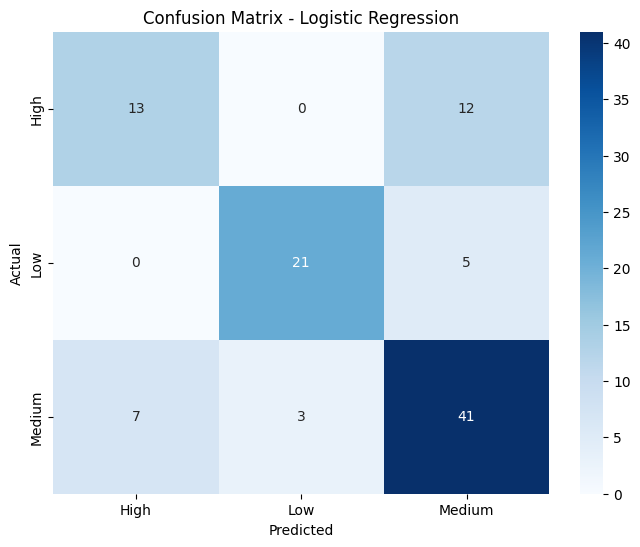

In [205]:
cm = confusion_matrix(y_test, y_pred_lgr)
cm_df = pd.DataFrame(cm, 
                     index=['High', 'Low', 'Medium'], 
                     columns=['High', 'Low', 'Medium'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['High', 'Low', 'Medium'],
            yticklabels=['High', 'Low', 'Medium'])
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [206]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = LgR.predict_proba(X_test)
classes = LgR.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['High' 'Low' 'Medium']
Prediction probabilities shape: (102, 3)


In [207]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [208]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
High     : 0.8951
Low      : 0.9626
Medium   : 0.8124
Micro-avg : 0.9029


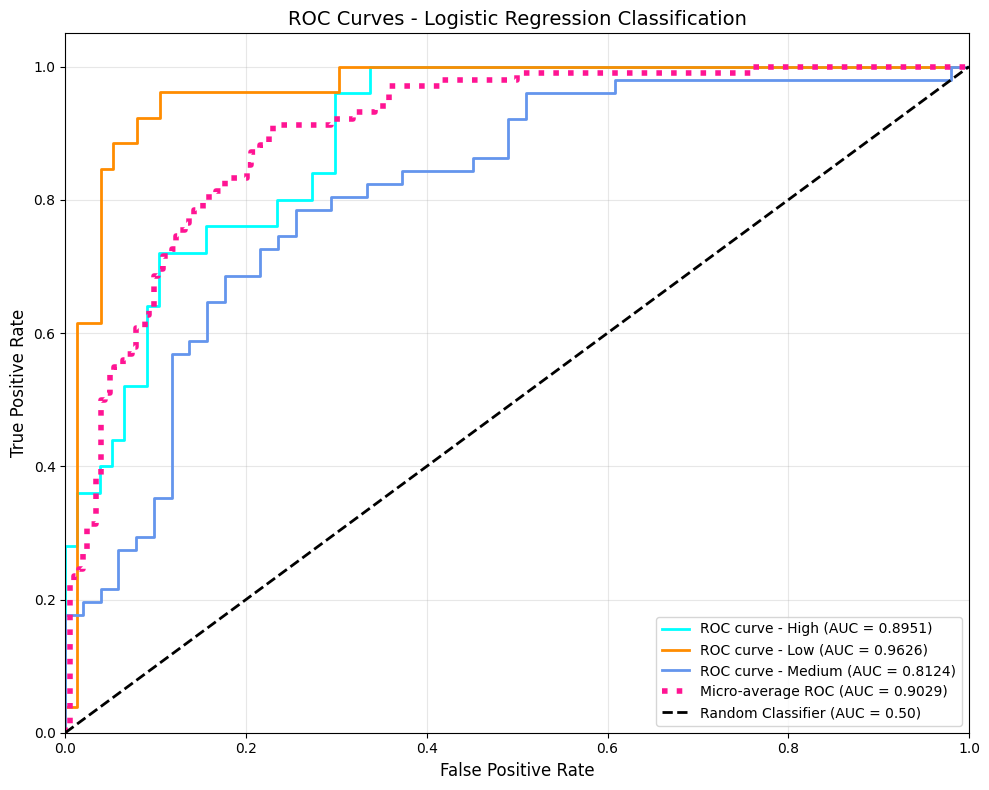

In [209]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [210]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.8709
One-vs-One (Weighted)  : 0.8892
Micro-average          : 0.9029


#### Random Forest Classifier

In [211]:
RFC = RandomForestClassifier(
    random_state=42,
    verbose=1  # Shows training progress
)
RFC

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [212]:
%%time
RFC.fit(X_train, y_train)

CPU times: total: 203 ms
Wall time: 165 ms


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [213]:
y_pred_rfc = RFC.predict(X_test)
y_pred_rfc

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


array(['Low', 'Medium', 'Low', 'Medium', 'Medium', 'Medium', 'Medium',
       'High', 'High', 'Medium', 'High', 'Low', 'Medium', 'Medium',
       'Medium', 'Low', 'Medium', 'Low', 'Medium', 'Medium', 'Medium',
       'Low', 'Low', 'Medium', 'Medium', 'Low', 'Medium', 'Medium',
       'Medium', 'Medium', 'Medium', 'Low', 'Low', 'Medium', 'High',
       'Medium', 'Low', 'High', 'Low', 'Medium', 'High', 'Low', 'High',
       'Medium', 'High', 'Medium', 'Medium', 'Medium', 'High', 'Low',
       'Low', 'Medium', 'Medium', 'Medium', 'High', 'Medium', 'High',
       'Medium', 'Low', 'Low', 'Medium', 'Low', 'Low', 'Medium', 'Low',
       'Medium', 'Medium', 'Medium', 'Medium', 'Low', 'Medium', 'Low',
       'High', 'High', 'Medium', 'High', 'Medium', 'Medium', 'Medium',
       'High', 'Medium', 'Medium', 'High', 'High', 'Medium', 'Low',
       'Medium', 'Medium', 'Medium', 'Medium', 'Medium', 'Low', 'Medium',
       'High', 'Low', 'Low', 'Medium', 'Low', 'High', 'Low', 'Medium',
       'Medium

In [214]:
y_test

399       Low
503    Medium
27        Low
119    Medium
492    Medium
        ...  
156       Low
4        High
20        Low
70     Medium
314    Medium
Name: MEDV_Class, Length: 102, dtype: object

In [215]:
accuracy_RFC = accuracy_score(y_test, y_pred_rfc)
precision_RFC = precision_score(y_test, y_pred_rfc, average='weighted')
recall_RFC = recall_score(y_test, y_pred_rfc, average='weighted')
f1_RFC = f1_score(y_test, y_pred_rfc, average='weighted')

# Save model if better
save_model_if_better_classification(
    model_name="Random Forest Classifier",
    model=RFC,
    scaler=scaler,
    accuracy=accuracy_RFC,
    precision=precision_RFC,
    recall=recall_RFC,
    f1=f1_RFC,
    parameters=RFC.get_params()
)

Random Forest Classifier (minmax): First time training - saving model
    New model saved to: saved_models_classification\random_forest_classifier_minmax_20250711_151813.pkl
    New scaler saved to: saved_models_classification\random_forest_classifier_scaler_minmax_20250711_151813.pkl


True

In [216]:
print("RANDOM FOREST CLASSIFICATION RESULTS")
print("="*50)
print(f"Accuracy:  {accuracy_RFC:.4f}")
print(f"Precision: {precision_RFC:.4f}")
print(f"Recall:    {recall_RFC:.4f}")
print(f"F1-Score:  {f1_RFC:.4f}")

RANDOM FOREST CLASSIFICATION RESULTS
Accuracy:  0.8627
Precision: 0.8651
Recall:    0.8627
F1-Score:  0.8594


In [217]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_rfc))


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

        High       0.89      0.68      0.77        25
         Low       0.89      0.96      0.93        26
      Medium       0.84      0.90      0.87        51

    accuracy                           0.86       102
   macro avg       0.87      0.85      0.86       102
weighted avg       0.87      0.86      0.86       102



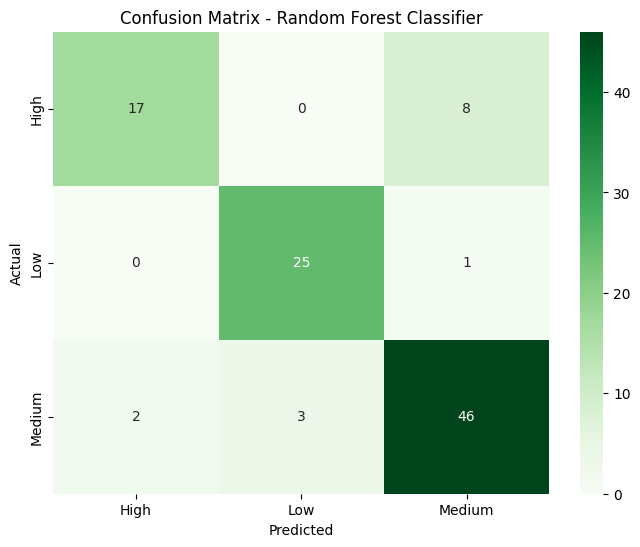

In [218]:
cm_rfc = confusion_matrix(y_test, y_pred_rfc)
cm_rfc_df = pd.DataFrame(cm_rfc, 
                         index=['High', 'Low', 'Medium'], 
                         columns=['High', 'Low', 'Medium'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rfc_df, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['High', 'Low', 'Medium'],
            yticklabels=['High', 'Low', 'Medium'])
plt.title('Confusion Matrix - Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [219]:
# ROC and AUC Analysis for Random Forest Classifier
print("ROC CURVE AND AUC ANALYSIS - RANDOM FOREST")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba_rfc = RFC.predict_proba(X_test)
classes_rfc = RFC.classes_
n_classes_rfc = len(classes_rfc)

print(f"Classes: {classes_rfc}")
print(f"Prediction probabilities shape: {y_pred_proba_rfc.shape}")

ROC CURVE AND AUC ANALYSIS - RANDOM FOREST
Classes: ['High' 'Low' 'Medium']
Prediction probabilities shape: (102, 3)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [220]:
# Convert multi-class to binary format for ROC analysis
y_test_bin_rfc = label_binarize(y_test, classes=classes_rfc)

# Compute ROC curve and AUC for each class
fpr_rfc = dict()
tpr_rfc = dict()
roc_auc_rfc = dict()

for i in range(n_classes_rfc):
    fpr_rfc[i], tpr_rfc[i], _ = roc_curve(y_test_bin_rfc[:, i], y_pred_proba_rfc[:, i])
    roc_auc_rfc[i] = auc(fpr_rfc[i], tpr_rfc[i])

# Compute micro-average ROC curve and AUC
fpr_rfc["micro"], tpr_rfc["micro"], _ = roc_curve(y_test_bin_rfc.ravel(), y_pred_proba_rfc.ravel())
roc_auc_rfc["micro"] = auc(fpr_rfc["micro"], tpr_rfc["micro"])

In [221]:
# Print AUC scores for Random Forest
print("\nAUC SCORES - RANDOM FOREST:")
print("-" * 30)
for i, class_name in enumerate(classes_rfc):
    print(f"{class_name:8} : {roc_auc_rfc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc_rfc['micro']:.4f}")


AUC SCORES - RANDOM FOREST:
------------------------------
High     : 0.9631
Low      : 0.9696
Medium   : 0.9216
Micro-avg : 0.9584


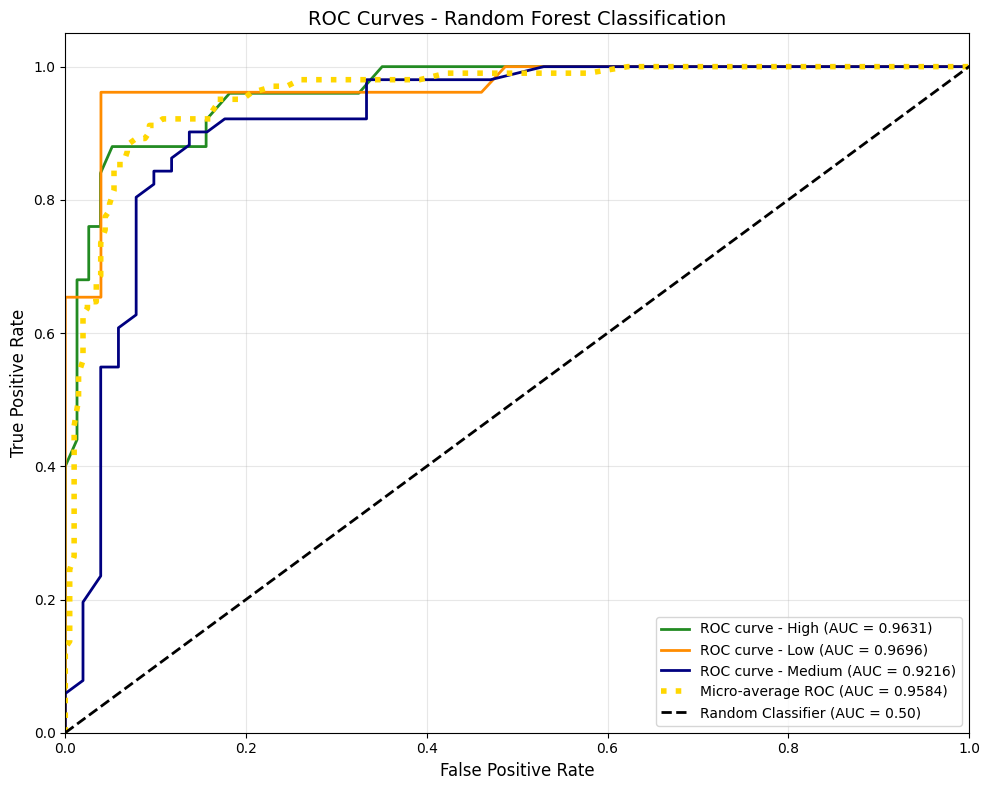

In [222]:
# Plot ROC curves for Random Forest
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(['forestgreen', 'darkorange', 'navy'])

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes_rfc), colors, classes_rfc):
    plt.plot(fpr_rfc[i], tpr_rfc[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc_rfc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr_rfc["micro"], tpr_rfc["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc_rfc["micro"]:.4f})',
         color='gold', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Random Forest Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [223]:
# Calculate overall AUC scores using different methods for Random Forest
auc_ovr_rfc = roc_auc_score(y_test, y_pred_proba_rfc, multi_class='ovr', average='weighted')
auc_ovo_rfc = roc_auc_score(y_test, y_pred_proba_rfc, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES - RANDOM FOREST:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr_rfc:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo_rfc:.4f}")
print(f"Micro-average          : {roc_auc_rfc['micro']:.4f}")


OVERALL AUC SCORES - RANDOM FOREST:
------------------------------
One-vs-Rest (Weighted) : 0.9440
One-vs-One (Weighted)  : 0.9512
Micro-average          : 0.9584



FEATURE IMPORTANCE - RANDOM FOREST CLASSIFIER (TOP 10)
    feature  importance
5        RM    0.226036
12    LSTAT    0.184592
4       NOX    0.094094
0      CRIM    0.092707
7       DIS    0.091344
2     INDUS    0.065766
6       AGE    0.057235
11        B    0.051168
10  PTRATIO    0.049195
9       TAX    0.042012


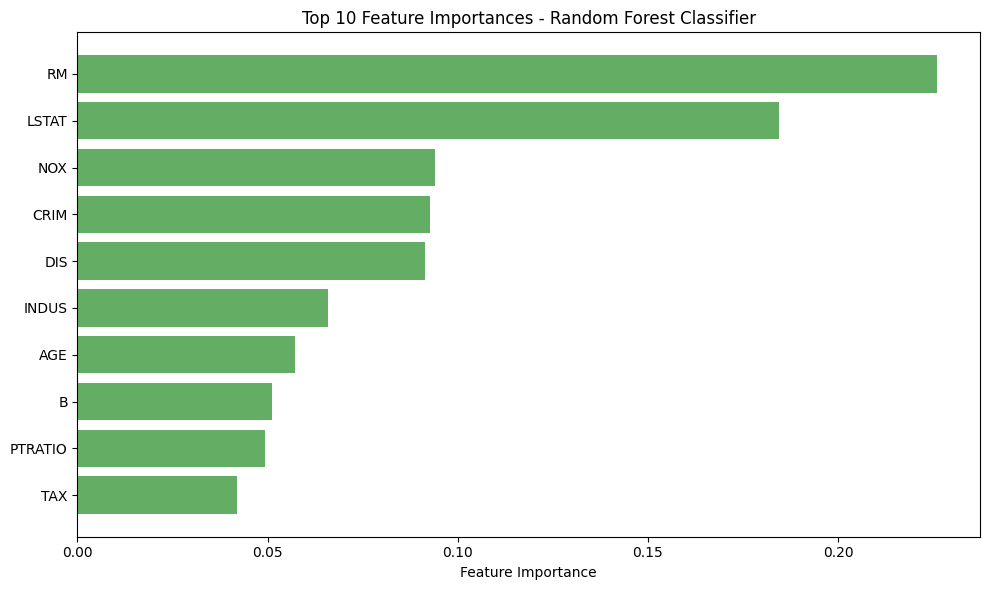

In [224]:
feature_names = boston.drop(columns=['MEDV', 'MEDV_Class']).columns

feature_importance_rfc = pd.DataFrame({
    'feature': feature_names,
    'importance': RFC.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFEATURE IMPORTANCE - RANDOM FOREST CLASSIFIER (TOP 10)")
print("="*60)
print(feature_importance_rfc.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance_rfc.head(10)
plt.barh(range(len(top_features)), top_features['importance'], color='forestgreen', alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances - Random Forest Classifier')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Support Vector Machine Classifier

In [225]:
SVC_model = SVC(
    random_state=42,
    verbose=True,  # Shows training progress
    probability=True  # Enable probability prediction for ROC analysis
)
SVC_model

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,True


In [226]:
%%time
SVC_model.fit(X_train, y_train)

[LibSVM]CPU times: total: 46.9 ms
Wall time: 26.6 ms


,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,True


In [227]:
y_pred_svc = SVC_model.predict(X_test)
y_pred_svc

array(['Low', 'Medium', 'Medium', 'Medium', 'Medium', 'Medium', 'Medium',
       'High', 'High', 'Medium', 'Medium', 'Medium', 'Medium', 'Medium',
       'Medium', 'Low', 'High', 'Low', 'Medium', 'Medium', 'Medium',
       'Low', 'Low', 'Medium', 'High', 'Low', 'High', 'Medium', 'Medium',
       'Medium', 'Medium', 'Low', 'Low', 'High', 'Medium', 'Medium',
       'Low', 'High', 'Low', 'Medium', 'High', 'Low', 'High', 'Medium',
       'High', 'Medium', 'Medium', 'High', 'High', 'Low', 'Low', 'Medium',
       'Medium', 'Medium', 'High', 'Medium', 'High', 'Medium', 'Low',
       'Low', 'Medium', 'Medium', 'Low', 'Medium', 'Low', 'Medium',
       'Medium', 'Medium', 'Medium', 'Low', 'Medium', 'Low', 'High',
       'High', 'Medium', 'High', 'Medium', 'Medium', 'Medium', 'High',
       'Medium', 'Low', 'High', 'High', 'Medium', 'Low', 'Medium',
       'Medium', 'Medium', 'High', 'High', 'Low', 'Medium', 'High', 'Low',
       'Low', 'Medium', 'Low', 'Medium', 'Medium', 'Medium', 'Medium'],
  

In [228]:
y_test

399       Low
503    Medium
27        Low
119    Medium
492    Medium
        ...  
156       Low
4        High
20        Low
70     Medium
314    Medium
Name: MEDV_Class, Length: 102, dtype: object

In [229]:
accuracy_SVC = accuracy_score(y_test, y_pred_svc)
precision_SVC = precision_score(y_test, y_pred_svc, average='weighted')
recall_SVC = recall_score(y_test, y_pred_svc, average='weighted')
f1_SVC = f1_score(y_test, y_pred_svc, average='weighted')

# Save model if better
save_model_if_better_classification(
    model_name="SVM Classifier",
    model=SVC_model,
    scaler=scaler,
    accuracy=accuracy_SVC,
    precision=precision_SVC,
    recall=recall_SVC,
    f1=f1_SVC,
    parameters=SVC_model.get_params()
)

SVM Classifier (minmax): First time training - saving model
    New model saved to: saved_models_classification\svm_classifier_minmax_20250711_151813.pkl
    New scaler saved to: saved_models_classification\svm_classifier_scaler_minmax_20250711_151813.pkl


True

In [230]:
print("SVM CLASSIFICATION RESULTS")
print("="*50)
print(f"Accuracy:  {accuracy_SVC:.4f}")
print(f"Precision: {precision_SVC:.4f}")
print(f"Recall:    {recall_SVC:.4f}")
print(f"F1-Score:  {f1_SVC:.4f}")

SVM CLASSIFICATION RESULTS
Accuracy:  0.7353
Precision: 0.7351
Recall:    0.7353
F1-Score:  0.7345


In [231]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_svc))


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

        High       0.65      0.60      0.62        25
         Low       0.84      0.81      0.82        26
      Medium       0.72      0.76      0.74        51

    accuracy                           0.74       102
   macro avg       0.74      0.72      0.73       102
weighted avg       0.74      0.74      0.73       102



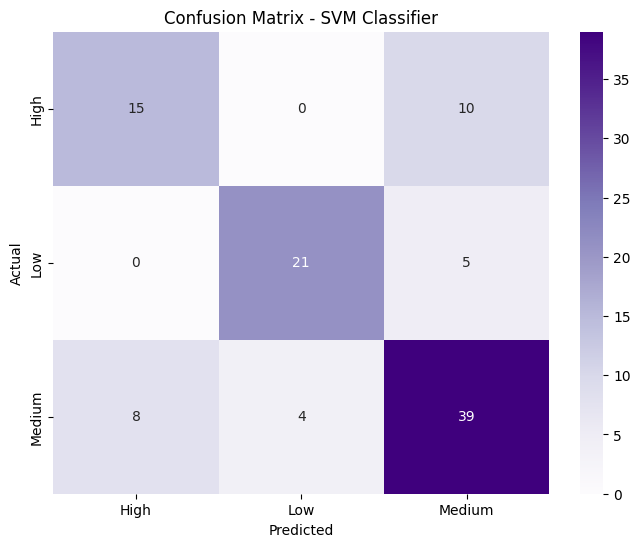

In [232]:
cm_svc = confusion_matrix(y_test, y_pred_svc)
cm_svc_df = pd.DataFrame(cm_svc, 
                         index=['High', 'Low', 'Medium'], 
                         columns=['High', 'Low', 'Medium'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_svc_df, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['High', 'Low', 'Medium'],
            yticklabels=['High', 'Low', 'Medium'])
plt.title('Confusion Matrix - SVM Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [233]:
# ROC and AUC Analysis for SVM Classifier
print("ROC CURVE AND AUC ANALYSIS - SVM CLASSIFIER")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba_svc = SVC_model.predict_proba(X_test)
classes_svc = SVC_model.classes_
n_classes_svc = len(classes_svc)

print(f"Classes: {classes_svc}")
print(f"Prediction probabilities shape: {y_pred_proba_svc.shape}")

ROC CURVE AND AUC ANALYSIS - SVM CLASSIFIER
Classes: ['High' 'Low' 'Medium']
Prediction probabilities shape: (102, 3)


In [234]:
# Convert multi-class to binary format for ROC analysis
y_test_bin_svc = label_binarize(y_test, classes=classes_svc)

# Compute ROC curve and AUC for each class
fpr_svc = dict()
tpr_svc = dict()
roc_auc_svc = dict()

for i in range(n_classes_svc):
    fpr_svc[i], tpr_svc[i], _ = roc_curve(y_test_bin_svc[:, i], y_pred_proba_svc[:, i])
    roc_auc_svc[i] = auc(fpr_svc[i], tpr_svc[i])

# Compute micro-average ROC curve and AUC
fpr_svc["micro"], tpr_svc["micro"], _ = roc_curve(y_test_bin_svc.ravel(), y_pred_proba_svc.ravel())
roc_auc_svc["micro"] = auc(fpr_svc["micro"], tpr_svc["micro"])

In [235]:
# Print AUC scores for SVM
print("\nAUC SCORES - SVM CLASSIFIER:")
print("-" * 30)
for i, class_name in enumerate(classes_svc):
    print(f"{class_name:8} : {roc_auc_svc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc_svc['micro']:.4f}")


AUC SCORES - SVM CLASSIFIER:
------------------------------
High     : 0.8997
Low      : 0.9534
Medium   : 0.8032
Micro-avg : 0.8989


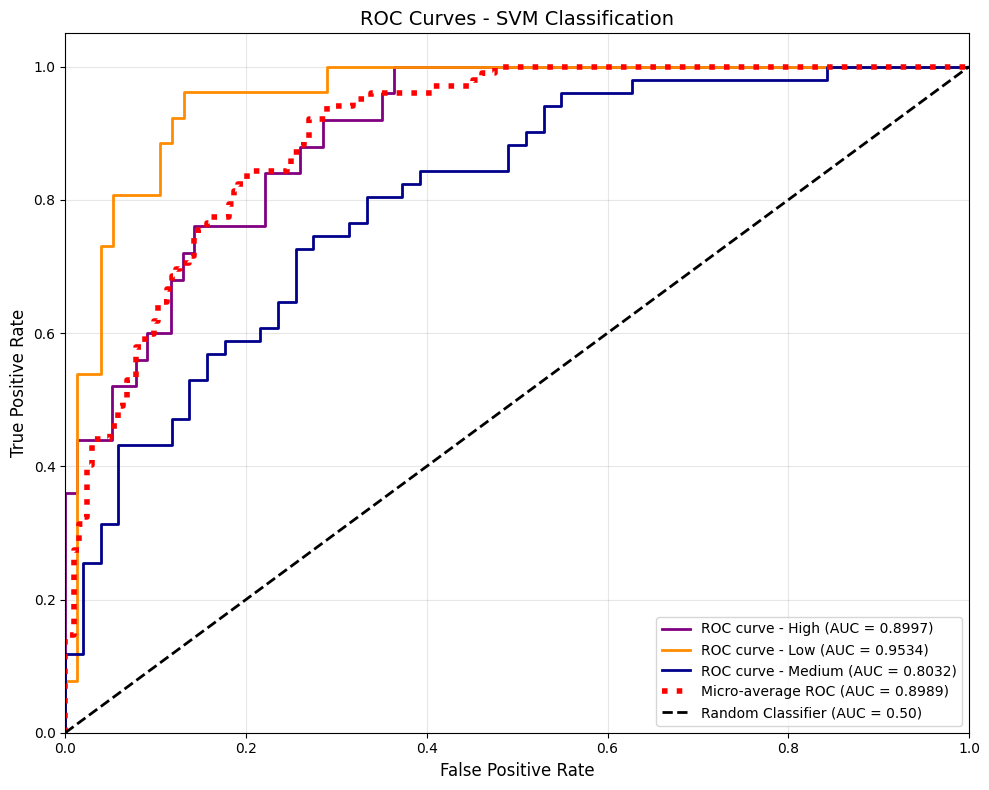

In [236]:
# Plot ROC curves for SVM
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(['purple', 'darkorange', 'darkblue'])

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes_svc), colors, classes_svc):
    plt.plot(fpr_svc[i], tpr_svc[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc_svc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr_svc["micro"], tpr_svc["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc_svc["micro"]:.4f})',
         color='red', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - SVM Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [237]:
# Calculate overall AUC scores using different methods for SVM
auc_ovr_svc = roc_auc_score(y_test, y_pred_proba_svc, multi_class='ovr', average='weighted')
auc_ovo_svc = roc_auc_score(y_test, y_pred_proba_svc, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES - SVM CLASSIFIER:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr_svc:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo_svc:.4f}")
print(f"Micro-average          : {roc_auc_svc['micro']:.4f}")


OVERALL AUC SCORES - SVM CLASSIFIER:
------------------------------
One-vs-Rest (Weighted) : 0.8651
One-vs-One (Weighted)  : 0.8846
Micro-average          : 0.8989


### Bagging Ensamble Learning

#### Tuning Logistic Regression

In [ ]:
# Create base Logistic Regression
base_lgr = LogisticRegression(random_state=42, max_iter=1000)

# Create Bagging Classifier
bagging_lgr_clf = BaggingClassifier(
    base_estimator=base_lgr,
    n_estimators=100,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_lgr_clf

In [ ]:
%%time
bagging_lgr_clf.fit(X_train, y_train)

In [ ]:
y_pred_bagging_lgr = bagging_lgr_clf.predict(X_test)
y_pred_bagging_lgr

In [ ]:
y_test

In [ ]:
accuracy_Bagging_LgR = accuracy_score(y_test, y_pred_bagging_lgr)
precision_Bagging_LgR = precision_score(y_test, y_pred_bagging_lgr, average='weighted')
recall_Bagging_LgR = recall_score(y_test, y_pred_bagging_lgr, average='weighted')
f1_Bagging_LgR = f1_score(y_test, y_pred_bagging_lgr, average='weighted')

# Save model if better
save_model_if_better_classification(
    model_name="Bagging Logistic Regression",
    model=bagging_lgr_clf,
    scaler=scaler,
    accuracy=accuracy_Bagging_LgR,
    precision=precision_Bagging_LgR,
    recall=recall_Bagging_LgR,
    f1=f1_Bagging_LgR,
    parameters=bagging_lgr_clf.get_params()
)

In [ ]:
print("BAGGING LOGISTIC REGRESSION CLASSIFICATION RESULTS")
print("="*60)
print(f"Accuracy:  {accuracy_Bagging_LgR:.4f}")
print(f"Precision: {precision_Bagging_LgR:.4f}")
print(f"Recall:    {recall_Bagging_LgR:.4f}")
print(f"F1-Score:  {f1_Bagging_LgR:.4f}")

In [ ]:
print("\nDETAILED CLASSIFICATION REPORT - BAGGING LOGISTIC REGRESSION")
print("="*60)
print(classification_report(y_test, y_pred_bagging_lgr))

In [ ]:
# Confusion Matrix
cm_bagging_lgr = confusion_matrix(y_test, y_pred_bagging_lgr)
cm_bagging_lgr_df = pd.DataFrame(cm_bagging_lgr, 
                                index=['High', 'Low', 'Medium'], 
                                columns=['High', 'Low', 'Medium'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_bagging_lgr_df, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['High', 'Low', 'Medium'],
            yticklabels=['High', 'Low', 'Medium'])
plt.title('Confusion Matrix - Bagging Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# ROC and AUC Analysis for Bagging Logistic Regression
print("ROC CURVE AND AUC ANALYSIS - BAGGING LOGISTIC REGRESSION")
print("="*60)

# Get prediction probabilities for all classes
y_pred_proba_bagging_lgr = bagging_lgr_clf.predict_proba(X_test)
classes_bagging_lgr = bagging_lgr_clf.classes_
n_classes_bagging_lgr = len(classes_bagging_lgr)

print(f"Classes: {classes_bagging_lgr}")
print(f"Prediction probabilities shape: {y_pred_proba_bagging_lgr.shape}")

In [ ]:
# Convert multi-class to binary format for ROC analysis
y_test_bin_bagging_lgr = label_binarize(y_test, classes=classes_bagging_lgr)

# Compute ROC curve and AUC for each class
fpr_bagging_lgr = dict()
tpr_bagging_lgr = dict()
roc_auc_bagging_lgr = dict()

for i in range(n_classes_bagging_lgr):
    fpr_bagging_lgr[i], tpr_bagging_lgr[i], _ = roc_curve(y_test_bin_bagging_lgr[:, i], y_pred_proba_bagging_lgr[:, i])
    roc_auc_bagging_lgr[i] = auc(fpr_bagging_lgr[i], tpr_bagging_lgr[i])

# Compute micro-average ROC curve and AUC
fpr_bagging_lgr["micro"], tpr_bagging_lgr["micro"], _ = roc_curve(y_test_bin_bagging_lgr.ravel(), y_pred_proba_bagging_lgr.ravel())
roc_auc_bagging_lgr["micro"] = auc(fpr_bagging_lgr["micro"], tpr_bagging_lgr["micro"])

In [ ]:
# Print AUC scores for Bagging Logistic Regression
print("\nAUC SCORES - BAGGING LOGISTIC REGRESSION:")
print("-" * 40)
for i, class_name in enumerate(classes_bagging_lgr):
    print(f"{class_name:8} : {roc_auc_bagging_lgr[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc_bagging_lgr['micro']:.4f}")

In [ ]:
# Plot ROC curves for Bagging Logistic Regression
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes_bagging_lgr), colors, classes_bagging_lgr):
    plt.plot(fpr_bagging_lgr[i], tpr_bagging_lgr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc_bagging_lgr[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr_bagging_lgr["micro"], tpr_bagging_lgr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc_bagging_lgr["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Bagging Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Calculate overall AUC scores
auc_ovr_bagging_lgr = roc_auc_score(y_test, y_pred_proba_bagging_lgr, multi_class='ovr', average='weighted')
auc_ovo_bagging_lgr = roc_auc_score(y_test, y_pred_proba_bagging_lgr, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES - BAGGING LOGISTIC REGRESSION:")
print("-" * 40)
print(f"One-vs-Rest (Weighted) : {auc_ovr_bagging_lgr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo_bagging_lgr:.4f}")
print(f"Micro-average          : {roc_auc_bagging_lgr['micro']:.4f}")

#### Tuning Random Forest Classifier

In [ ]:
# Create base Random Forest Classifier
base_rfc = RandomForestClassifier(random_state=42, verbose=1)

# Create Bagging Classifier with Random Forest
bagging_rfc_clf = BaggingClassifier(
    base_estimator=base_rfc,
    n_estimators=50,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8,
    max_samples=0.8
)

bagging_rfc_clf

In [ ]:
%%time
bagging_rfc_clf.fit(X_train, y_train)

In [ ]:
y_pred_bagging_rfc = bagging_rfc_clf.predict(X_test)
y_pred_bagging_rfc

In [ ]:
y_test

In [ ]:
accuracy_Bagging_RFC = accuracy_score(y_test, y_pred_bagging_rfc)
precision_Bagging_RFC = precision_score(y_test, y_pred_bagging_rfc, average='weighted')
recall_Bagging_RFC = recall_score(y_test, y_pred_bagging_rfc, average='weighted')
f1_Bagging_RFC = f1_score(y_test, y_pred_bagging_rfc, average='weighted')

# Save model if better
save_model_if_better_classification(
    model_name="Bagging Random Forest Classifier",
    model=bagging_rfc_clf,
    scaler=scaler,
    accuracy=accuracy_Bagging_RFC,
    precision=precision_Bagging_RFC,
    recall=recall_Bagging_RFC,
    f1=f1_Bagging_RFC,
    parameters=bagging_rfc_clf.get_params()
)

In [ ]:
print("BAGGING RANDOM FOREST CLASSIFICATION RESULTS")
print("="*60)
print(f"Accuracy:  {accuracy_Bagging_RFC:.4f}")
print(f"Precision: {precision_Bagging_RFC:.4f}")
print(f"Recall:    {recall_Bagging_RFC:.4f}")
print(f"F1-Score:  {f1_Bagging_RFC:.4f}")

In [ ]:
print("\nDETAILED CLASSIFICATION REPORT - BAGGING RANDOM FOREST")
print("="*60)
print(classification_report(y_test, y_pred_bagging_rfc))

In [ ]:
# Confusion Matrix
cm_bagging_rfc = confusion_matrix(y_test, y_pred_bagging_rfc)
cm_bagging_rfc_df = pd.DataFrame(cm_bagging_rfc, 
                                index=['High', 'Low', 'Medium'], 
                                columns=['High', 'Low', 'Medium'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_bagging_rfc_df, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['High', 'Low', 'Medium'],
            yticklabels=['High', 'Low', 'Medium'])
plt.title('Confusion Matrix - Bagging Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# ROC and AUC Analysis for Bagging Random Forest Classifier
print("ROC CURVE AND AUC ANALYSIS - BAGGING RANDOM FOREST")
print("="*60)

# Get prediction probabilities for all classes
y_pred_proba_bagging_rfc = bagging_rfc_clf.predict_proba(X_test)
classes_bagging_rfc = bagging_rfc_clf.classes_
n_classes_bagging_rfc = len(classes_bagging_rfc)

print(f"Classes: {classes_bagging_rfc}")
print(f"Prediction probabilities shape: {y_pred_proba_bagging_rfc.shape}")

In [ ]:
# Convert multi-class to binary format for ROC analysis
y_test_bin_bagging_rfc = label_binarize(y_test, classes=classes_bagging_rfc)

# Compute ROC curve and AUC for each class
fpr_bagging_rfc = dict()
tpr_bagging_rfc = dict()
roc_auc_bagging_rfc = dict()

for i in range(n_classes_bagging_rfc):
    fpr_bagging_rfc[i], tpr_bagging_rfc[i], _ = roc_curve(y_test_bin_bagging_rfc[:, i], y_pred_proba_bagging_rfc[:, i])
    roc_auc_bagging_rfc[i] = auc(fpr_bagging_rfc[i], tpr_bagging_rfc[i])

# Compute micro-average ROC curve and AUC
fpr_bagging_rfc["micro"], tpr_bagging_rfc["micro"], _ = roc_curve(y_test_bin_bagging_rfc.ravel(), y_pred_proba_bagging_rfc.ravel())
roc_auc_bagging_rfc["micro"] = auc(fpr_bagging_rfc["micro"], tpr_bagging_rfc["micro"])

In [ ]:
# Print AUC scores for Bagging Random Forest
print("\nAUC SCORES - BAGGING RANDOM FOREST:")
print("-" * 40)
for i, class_name in enumerate(classes_bagging_rfc):
    print(f"{class_name:8} : {roc_auc_bagging_rfc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc_bagging_rfc['micro']:.4f}")

In [ ]:
# Plot ROC curves for Bagging Random Forest
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(['forestgreen', 'darkorange', 'darkblue'])

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes_bagging_rfc), colors, classes_bagging_rfc):
    plt.plot(fpr_bagging_rfc[i], tpr_bagging_rfc[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc_bagging_rfc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr_bagging_rfc["micro"], tpr_bagging_rfc["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc_bagging_rfc["micro"]:.4f})',
         color='gold', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Bagging Random Forest Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Calculate overall AUC scores
auc_ovr_bagging_rfc = roc_auc_score(y_test, y_pred_proba_bagging_rfc, multi_class='ovr', average='weighted')
auc_ovo_bagging_rfc = roc_auc_score(y_test, y_pred_proba_bagging_rfc, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES - BAGGING RANDOM FOREST:")
print("-" * 40)
print(f"One-vs-Rest (Weighted) : {auc_ovr_bagging_rfc:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo_bagging_rfc:.4f}")
print(f"Micro-average          : {roc_auc_bagging_rfc['micro']:.4f}")

#### Tuning Support Vector Machine Classifier

In [ ]:
# Create base Support Vector Classifier
base_svc = SVC(random_state=42, probability=True, verbose=True)

# Create Bagging Classifier with SVM
bagging_svc_clf = BaggingClassifier(
    base_estimator=base_svc,
    n_estimators=50,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8,
    max_samples=0.8
)

bagging_svc_clf

In [ ]:
%%time
bagging_svc_clf.fit(X_train, y_train)

In [ ]:
y_pred_bagging_svc = bagging_svc_clf.predict(X_test)
y_pred_bagging_svc

In [ ]:
y_test

In [ ]:
accuracy_Bagging_SVC = accuracy_score(y_test, y_pred_bagging_svc)
precision_Bagging_SVC = precision_score(y_test, y_pred_bagging_svc, average='weighted')
recall_Bagging_SVC = recall_score(y_test, y_pred_bagging_svc, average='weighted')
f1_Bagging_SVC = f1_score(y_test, y_pred_bagging_svc, average='weighted')

# Save model if better
save_model_if_better_classification(
    model_name="Bagging SVM Classifier",
    model=bagging_svc_clf,
    scaler=scaler,
    accuracy=accuracy_Bagging_SVC,
    precision=precision_Bagging_SVC,
    recall=recall_Bagging_SVC,
    f1=f1_Bagging_SVC,
    parameters=bagging_svc_clf.get_params()
)

In [ ]:
print("BAGGING SVM CLASSIFICATION RESULTS")
print("="*60)
print(f"Accuracy:  {accuracy_Bagging_SVC:.4f}")
print(f"Precision: {precision_Bagging_SVC:.4f}")
print(f"Recall:    {recall_Bagging_SVC:.4f}")
print(f"F1-Score:  {f1_Bagging_SVC:.4f}")

In [ ]:
print("\nDETAILED CLASSIFICATION REPORT - BAGGING SVM")
print("="*60)
print(classification_report(y_test, y_pred_bagging_svc))

In [ ]:
# Confusion Matrix
cm_bagging_svc = confusion_matrix(y_test, y_pred_bagging_svc)
cm_bagging_svc_df = pd.DataFrame(cm_bagging_svc, 
                                index=['High', 'Low', 'Medium'], 
                                columns=['High', 'Low', 'Medium'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_bagging_svc_df, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['High', 'Low', 'Medium'],
            yticklabels=['High', 'Low', 'Medium'])
plt.title('Confusion Matrix - Bagging SVM Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# ROC and AUC Analysis for Bagging SVM Classifier
print("ROC CURVE AND AUC ANALYSIS - BAGGING SVM")
print("="*60)

# Get prediction probabilities for all classes
y_pred_proba_bagging_svc = bagging_svc_clf.predict_proba(X_test)
classes_bagging_svc = bagging_svc_clf.classes_
n_classes_bagging_svc = len(classes_bagging_svc)

print(f"Classes: {classes_bagging_svc}")
print(f"Prediction probabilities shape: {y_pred_proba_bagging_svc.shape}")

In [ ]:
# Convert multi-class to binary format for ROC analysis
y_test_bin_bagging_svc = label_binarize(y_test, classes=classes_bagging_svc)

# Compute ROC curve and AUC for each class
fpr_bagging_svc = dict()
tpr_bagging_svc = dict()
roc_auc_bagging_svc = dict()

for i in range(n_classes_bagging_svc):
    fpr_bagging_svc[i], tpr_bagging_svc[i], _ = roc_curve(y_test_bin_bagging_svc[:, i], y_pred_proba_bagging_svc[:, i])
    roc_auc_bagging_svc[i] = auc(fpr_bagging_svc[i], tpr_bagging_svc[i])

# Compute micro-average ROC curve and AUC
fpr_bagging_svc["micro"], tpr_bagging_svc["micro"], _ = roc_curve(y_test_bin_bagging_svc.ravel(), y_pred_proba_bagging_svc.ravel())
roc_auc_bagging_svc["micro"] = auc(fpr_bagging_svc["micro"], tpr_bagging_svc["micro"])

In [ ]:
# Print AUC scores for Bagging SVM
print("\nAUC SCORES - BAGGING SVM:")
print("-" * 40)
for i, class_name in enumerate(classes_bagging_svc):
    print(f"{class_name:8} : {roc_auc_bagging_svc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc_bagging_svc['micro']:.4f}")

In [ ]:
# Plot ROC curves for Bagging SVM
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(['purple', 'darkorange', 'darkblue'])

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes_bagging_svc), colors, classes_bagging_svc):
    plt.plot(fpr_bagging_svc[i], tpr_bagging_svc[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc_bagging_svc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr_bagging_svc["micro"], tpr_bagging_svc["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc_bagging_svc["micro"]:.4f})',
         color='red', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Bagging SVM Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Calculate overall AUC scores
auc_ovr_bagging_svc = roc_auc_score(y_test, y_pred_proba_bagging_svc, multi_class='ovr', average='weighted')
auc_ovo_bagging_svc = roc_auc_score(y_test, y_pred_proba_bagging_svc, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES - BAGGING SVM:")
print("-" * 40)
print(f"One-vs-Rest (Weighted) : {auc_ovr_bagging_svc:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo_bagging_svc:.4f}")
print(f"Micro-average          : {roc_auc_bagging_svc['micro']:.4f}")

### Gradient Boosting

In [ ]:
# Create Gradient Boosting Classifier
GBC = GradientBoostingClassifier(
    random_state=42,
    verbose=1  # Shows training progress
)
GBC

In [ ]:
%%time
GBC.fit(X_train, y_train)

In [ ]:
y_pred_gbc = GBC.predict(X_test)
y_pred_gbc

In [ ]:
y_test

In [ ]:
accuracy_GBC = accuracy_score(y_test, y_pred_gbc)
precision_GBC = precision_score(y_test, y_pred_gbc, average='weighted')
recall_GBC = recall_score(y_test, y_pred_gbc, average='weighted')
f1_GBC = f1_score(y_test, y_pred_gbc, average='weighted')

# Save model if better
save_model_if_better_classification(
    model_name="Gradient Boosting Classifier",
    model=GBC,
    scaler=scaler,
    accuracy=accuracy_GBC,
    precision=precision_GBC,
    recall=recall_GBC,
    f1=f1_GBC,
    parameters=GBC.get_params()
)

In [ ]:
print("GRADIENT BOOSTING CLASSIFICATION RESULTS")
print("="*60)
print(f"Accuracy:  {accuracy_GBC:.4f}")
print(f"Precision: {precision_GBC:.4f}")
print(f"Recall:    {recall_GBC:.4f}")
print(f"F1-Score:  {f1_GBC:.4f}")

In [ ]:
print("\nDETAILED CLASSIFICATION REPORT - GRADIENT BOOSTING")
print("="*60)
print(classification_report(y_test, y_pred_gbc))

In [ ]:
# Confusion Matrix
cm_gbc = confusion_matrix(y_test, y_pred_gbc)
cm_gbc_df = pd.DataFrame(cm_gbc, 
                        index=['High', 'Low', 'Medium'], 
                        columns=['High', 'Low', 'Medium'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_gbc_df, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['High', 'Low', 'Medium'],
            yticklabels=['High', 'Low', 'Medium'])
plt.title('Confusion Matrix - Gradient Boosting Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# ROC and AUC Analysis for Gradient Boosting Classifier
print("ROC CURVE AND AUC ANALYSIS - GRADIENT BOOSTING")
print("="*60)

# Get prediction probabilities for all classes
y_pred_proba_gbc = GBC.predict_proba(X_test)
classes_gbc = GBC.classes_
n_classes_gbc = len(classes_gbc)

print(f"Classes: {classes_gbc}")
print(f"Prediction probabilities shape: {y_pred_proba_gbc.shape}")

In [ ]:
# Convert multi-class to binary format for ROC analysis
y_test_bin_gbc = label_binarize(y_test, classes=classes_gbc)

# Compute ROC curve and AUC for each class
fpr_gbc = dict()
tpr_gbc = dict()
roc_auc_gbc = dict()

for i in range(n_classes_gbc):
    fpr_gbc[i], tpr_gbc[i], _ = roc_curve(y_test_bin_gbc[:, i], y_pred_proba_gbc[:, i])
    roc_auc_gbc[i] = auc(fpr_gbc[i], tpr_gbc[i])

# Compute micro-average ROC curve and AUC
fpr_gbc["micro"], tpr_gbc["micro"], _ = roc_curve(y_test_bin_gbc.ravel(), y_pred_proba_gbc.ravel())
roc_auc_gbc["micro"] = auc(fpr_gbc["micro"], tpr_gbc["micro"])

In [ ]:
# Print AUC scores for Gradient Boosting
print("\nAUC SCORES - GRADIENT BOOSTING:")
print("-" * 40)
for i, class_name in enumerate(classes_gbc):
    print(f"{class_name:8} : {roc_auc_gbc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc_gbc['micro']:.4f}")

In [ ]:
# Plot ROC curves for Gradient Boosting
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(['orange', 'darkorange', 'chocolate'])

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes_gbc), colors, classes_gbc):
    plt.plot(fpr_gbc[i], tpr_gbc[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc_gbc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr_gbc["micro"], tpr_gbc["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc_gbc["micro"]:.4f})',
         color='red', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Gradient Boosting Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Calculate overall AUC scores using different methods for Gradient Boosting
auc_ovr_gbc = roc_auc_score(y_test, y_pred_proba_gbc, multi_class='ovr', average='weighted')
auc_ovo_gbc = roc_auc_score(y_test, y_pred_proba_gbc, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES - GRADIENT BOOSTING:")
print("-" * 40)
print(f"One-vs-Rest (Weighted) : {auc_ovr_gbc:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo_gbc:.4f}")
print(f"Micro-average          : {roc_auc_gbc['micro']:.4f}")

In [ ]:
# Feature Importance for Gradient Boosting
feature_names = boston.drop(columns=['MEDV', 'MEDV_Class']).columns

feature_importance_gbc = pd.DataFrame({
    'feature': feature_names,
    'importance': GBC.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFEATURE IMPORTANCE - GRADIENT BOOSTING CLASSIFIER (TOP 10)")
print("="*60)
print(feature_importance_gbc.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance_gbc.head(10)
plt.barh(range(len(top_features)), top_features['importance'], color='orange', alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances - Gradient Boosting Classifier')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### AdaBoost

In [ ]:
# Create AdaBoost Classifier
ABC = AdaBoostClassifier(
    random_state=42,
    algorithm='SAMME'  # Supports multi-class classification
)
ABC

In [ ]:
%%time
ABC.fit(X_train, y_train)

In [ ]:
y_pred_abc = ABC.predict(X_test)
y_pred_abc

In [ ]:
y_test

In [ ]:
accuracy_ABC = accuracy_score(y_test, y_pred_abc)
precision_ABC = precision_score(y_test, y_pred_abc, average='weighted')
recall_ABC = recall_score(y_test, y_pred_abc, average='weighted')
f1_ABC = f1_score(y_test, y_pred_abc, average='weighted')

# Save model if better
save_model_if_better_classification(
    model_name="AdaBoost Classifier",
    model=ABC,
    scaler=scaler,
    accuracy=accuracy_ABC,
    precision=precision_ABC,
    recall=recall_ABC,
    f1=f1_ABC,
    parameters=ABC.get_params()
)

In [ ]:
print("ADABOOST CLASSIFICATION RESULTS")
print("="*60)
print(f"Accuracy:  {accuracy_ABC:.4f}")
print(f"Precision: {precision_ABC:.4f}")
print(f"Recall:    {recall_ABC:.4f}")
print(f"F1-Score:  {f1_ABC:.4f}")

In [ ]:
print("\nDETAILED CLASSIFICATION REPORT - ADABOOST")
print("="*60)
print(classification_report(y_test, y_pred_abc))

In [ ]:
# Confusion Matrix
cm_abc = confusion_matrix(y_test, y_pred_abc)
cm_abc_df = pd.DataFrame(cm_abc, 
                        index=['High', 'Low', 'Medium'], 
                        columns=['High', 'Low', 'Medium'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_abc_df, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['High', 'Low', 'Medium'],
            yticklabels=['High', 'Low', 'Medium'])
plt.title('Confusion Matrix - AdaBoost Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# ROC and AUC Analysis for AdaBoost Classifier
print("ROC CURVE AND AUC ANALYSIS - ADABOOST")
print("="*60)

# Get prediction probabilities for all classes
y_pred_proba_abc = ABC.predict_proba(X_test)
classes_abc = ABC.classes_
n_classes_abc = len(classes_abc)

print(f"Classes: {classes_abc}")
print(f"Prediction probabilities shape: {y_pred_proba_abc.shape}")

In [ ]:
# Convert multi-class to binary format for ROC analysis
y_test_bin_abc = label_binarize(y_test, classes=classes_abc)

# Compute ROC curve and AUC for each class
fpr_abc = dict()
tpr_abc = dict()
roc_auc_abc = dict()

for i in range(n_classes_abc):
    fpr_abc[i], tpr_abc[i], _ = roc_curve(y_test_bin_abc[:, i], y_pred_proba_abc[:, i])
    roc_auc_abc[i] = auc(fpr_abc[i], tpr_abc[i])

# Compute micro-average ROC curve and AUC
fpr_abc["micro"], tpr_abc["micro"], _ = roc_curve(y_test_bin_abc.ravel(), y_pred_proba_abc.ravel())
roc_auc_abc["micro"] = auc(fpr_abc["micro"], tpr_abc["micro"])

In [ ]:
# Print AUC scores for AdaBoost
print("\nAUC SCORES - ADABOOST:")
print("-" * 40)
for i, class_name in enumerate(classes_abc):
    print(f"{class_name:8} : {roc_auc_abc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc_abc['micro']:.4f}")

In [ ]:
# Plot ROC curves for AdaBoost
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(['red', 'darkred', 'crimson'])

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes_abc), colors, classes_abc):
    plt.plot(fpr_abc[i], tpr_abc[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc_abc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr_abc["micro"], tpr_abc["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc_abc["micro"]:.4f})',
         color='blue', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - AdaBoost Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Calculate overall AUC scores using different methods for AdaBoost
auc_ovr_abc = roc_auc_score(y_test, y_pred_proba_abc, multi_class='ovr', average='weighted')
auc_ovo_abc = roc_auc_score(y_test, y_pred_proba_abc, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES - ADABOOST:")
print("-" * 40)
print(f"One-vs-Rest (Weighted) : {auc_ovr_abc:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo_abc:.4f}")
print(f"Micro-average          : {roc_auc_abc['micro']:.4f}")

In [ ]:
# Feature Importance for AdaBoost
feature_names = boston.drop(columns=['MEDV', 'MEDV_Class']).columns

feature_importance_abc = pd.DataFrame({
    'feature': feature_names,
    'importance': ABC.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFEATURE IMPORTANCE - ADABOOST CLASSIFIER (TOP 10)")
print("="*60)
print(feature_importance_abc.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance_abc.head(10)
plt.barh(range(len(top_features)), top_features['importance'], color='red', alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances - AdaBoost Classifier')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### LightGBM

In [ ]:
# Create LightGBM Classifier
LGBM = LGBMClassifier(
    random_state=42,
    verbose=1,  # Shows training progress
    objective='multiclass',
    num_class=3,
    metric='multi_logloss'
)
LGBM

In [ ]:
%%time
LGBM.fit(X_train, y_train)

In [ ]:
y_pred_lgbm = LGBM.predict(X_test)
y_pred_lgbm

In [ ]:
y_test

In [ ]:
accuracy_LGBM = accuracy_score(y_test, y_pred_lgbm)
precision_LGBM = precision_score(y_test, y_pred_lgbm, average='weighted')
recall_LGBM = recall_score(y_test, y_pred_lgbm, average='weighted')
f1_LGBM = f1_score(y_test, y_pred_lgbm, average='weighted')

# Save model if better
save_model_if_better_classification(
    model_name="LightGBM Classifier",
    model=LGBM,
    scaler=scaler,
    accuracy=accuracy_LGBM,
    precision=precision_LGBM,
    recall=recall_LGBM,
    f1=f1_LGBM,
    parameters=LGBM.get_params()
)

In [ ]:
print("LIGHTGBM CLASSIFICATION RESULTS")
print("="*60)
print(f"Accuracy:  {accuracy_LGBM:.4f}")
print(f"Precision: {precision_LGBM:.4f}")
print(f"Recall:    {recall_LGBM:.4f}")
print(f"F1-Score:  {f1_LGBM:.4f}")

In [ ]:
print("\nDETAILED CLASSIFICATION REPORT - LIGHTGBM")
print("="*60)
print(classification_report(y_test, y_pred_lgbm))

In [ ]:
# Confusion Matrix
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
cm_lgbm_df = pd.DataFrame(cm_lgbm, 
                         index=['High', 'Low', 'Medium'], 
                         columns=['High', 'Low', 'Medium'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lgbm_df, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['High', 'Low', 'Medium'],
            yticklabels=['High', 'Low', 'Medium'])
plt.title('Confusion Matrix - LightGBM Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# ROC and AUC Analysis for LightGBM Classifier
print("ROC CURVE AND AUC ANALYSIS - LIGHTGBM")
print("="*60)

# Get prediction probabilities for all classes
y_pred_proba_lgbm = LGBM.predict_proba(X_test)
classes_lgbm = LGBM.classes_
n_classes_lgbm = len(classes_lgbm)

print(f"Classes: {classes_lgbm}")
print(f"Prediction probabilities shape: {y_pred_proba_lgbm.shape}")

In [ ]:
# Convert multi-class to binary format for ROC analysis
y_test_bin_lgbm = label_binarize(y_test, classes=classes_lgbm)

# Compute ROC curve and AUC for each class
fpr_lgbm = dict()
tpr_lgbm = dict()
roc_auc_lgbm = dict()

for i in range(n_classes_lgbm):
    fpr_lgbm[i], tpr_lgbm[i], _ = roc_curve(y_test_bin_lgbm[:, i], y_pred_proba_lgbm[:, i])
    roc_auc_lgbm[i] = auc(fpr_lgbm[i], tpr_lgbm[i])

# Compute micro-average ROC curve and AUC
fpr_lgbm["micro"], tpr_lgbm["micro"], _ = roc_curve(y_test_bin_lgbm.ravel(), y_pred_proba_lgbm.ravel())
roc_auc_lgbm["micro"] = auc(fpr_lgbm["micro"], tpr_lgbm["micro"])

In [ ]:
# Print AUC scores for LightGBM
print("\nAUC SCORES - LIGHTGBM:")
print("-" * 40)
for i, class_name in enumerate(classes_lgbm):
    print(f"{class_name:8} : {roc_auc_lgbm[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc_lgbm['micro']:.4f}")

In [ ]:
# Plot ROC curves for LightGBM
plt.figure(figsize=(10, 8))

# Colors for different classes (using green theme for LightGBM)
colors = cycle(['lightgreen', 'darkgreen', 'forestgreen'])

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes_lgbm), colors, classes_lgbm):
    plt.plot(fpr_lgbm[i], tpr_lgbm[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc_lgbm[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr_lgbm["micro"], tpr_lgbm["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc_lgbm["micro"]:.4f})',
         color='lime', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - LightGBM Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Calculate overall AUC scores using different methods for LightGBM
auc_ovr_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm, multi_class='ovr', average='weighted')
auc_ovo_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES - LIGHTGBM:")
print("-" * 40)
print(f"One-vs-Rest (Weighted) : {auc_ovr_lgbm:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo_lgbm:.4f}")
print(f"Micro-average          : {roc_auc_lgbm['micro']:.4f}")

In [ ]:
# Feature Importance for LightGBM
feature_names = boston.drop(columns=['MEDV', 'MEDV_Class']).columns

feature_importance_lgbm = pd.DataFrame({
    'feature': feature_names,
    'importance': LGBM.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFEATURE IMPORTANCE - LIGHTGBM CLASSIFIER (TOP 10)")
print("="*60)
print(feature_importance_lgbm.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance_lgbm.head(10)
plt.barh(range(len(top_features)), top_features['importance'], color='lightgreen', alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances - LightGBM Classifier')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Stacking

In [ ]:
# Define base classifiers for stacking
base_classifiers = [
    ('logistic', LogisticRegression(random_state=42, max_iter=1000)),
    ('random_forest', RandomForestClassifier(random_state=42, n_estimators=100)),
    ('svm', SVC(random_state=42, probability=True)),
    ('gradient_boost', GradientBoostingClassifier(random_state=42, n_estimators=100)),
    ('ada_boost', AdaBoostClassifier(random_state=42, n_estimators=100, algorithm='SAMME')),
    ('lightgbm', LGBMClassifier(random_state=42, verbose=-1, objective='multiclass', num_class=3))
]

# Define meta-classifier (final estimator)
meta_classifier = LogisticRegression(random_state=42, max_iter=1000)

In [ ]:
# Create Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_classifiers,
    final_estimator=meta_classifier,
    cv=5,  # Cross-validation folds for training base classifiers
    stack_method='predict_proba',  # Use probabilities for stacking
    n_jobs=-1,
    verbose=1
)

stacking_clf

In [ ]:
%%time
print("Training Stacking Classifier with base models:")
for name, model in base_classifiers:
    print(f"  - {name}: {type(model).__name__}")
print(f"Meta-classifier: {type(meta_classifier).__name__}")
print()

stacking_clf.fit(X_train, y_train)

In [ ]:
y_pred_stacking = stacking_clf.predict(X_test)
y_pred_stacking

In [ ]:
y_test

In [ ]:
accuracy_Stacking = accuracy_score(y_test, y_pred_stacking)
precision_Stacking = precision_score(y_test, y_pred_stacking, average='weighted')
recall_Stacking = recall_score(y_test, y_pred_stacking, average='weighted')
f1_Stacking = f1_score(y_test, y_pred_stacking, average='weighted')

# Save model if better
save_model_if_better_classification(
    model_name="Stacking Classifier",
    model=stacking_clf,
    scaler=scaler,
    accuracy=accuracy_Stacking,
    precision=precision_Stacking,
    recall=recall_Stacking,
    f1=f1_Stacking,
    parameters=stacking_clf.get_params()
)

In [ ]:
print("STACKING CLASSIFICATION RESULTS")
print("="*60)
print(f"Accuracy:  {accuracy_Stacking:.4f}")
print(f"Precision: {precision_Stacking:.4f}")
print(f"Recall:    {recall_Stacking:.4f}")
print(f"F1-Score:  {f1_Stacking:.4f}")

In [ ]:
print("\nDETAILED CLASSIFICATION REPORT - STACKING")
print("="*60)
print(classification_report(y_test, y_pred_stacking))

In [ ]:
# Confusion Matrix
cm_stacking = confusion_matrix(y_test, y_pred_stacking)
cm_stacking_df = pd.DataFrame(cm_stacking, 
                             index=['High', 'Low', 'Medium'], 
                             columns=['High', 'Low', 'Medium'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_stacking_df, annot=True, fmt='d', cmap='viridis', 
            xticklabels=['High', 'Low', 'Medium'],
            yticklabels=['High', 'Low', 'Medium'])
plt.title('Confusion Matrix - Stacking Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# ROC and AUC Analysis for Stacking Classifier
print("ROC CURVE AND AUC ANALYSIS - STACKING")
print("="*60)

# Get prediction probabilities for all classes
y_pred_proba_stacking = stacking_clf.predict_proba(X_test)
classes_stacking = stacking_clf.classes_
n_classes_stacking = len(classes_stacking)

print(f"Classes: {classes_stacking}")
print(f"Prediction probabilities shape: {y_pred_proba_stacking.shape}")

In [ ]:
# Convert multi-class to binary format for ROC analysis
y_test_bin_stacking = label_binarize(y_test, classes=classes_stacking)

# Compute ROC curve and AUC for each class
fpr_stacking = dict()
tpr_stacking = dict()
roc_auc_stacking = dict()

for i in range(n_classes_stacking):
    fpr_stacking[i], tpr_stacking[i], _ = roc_curve(y_test_bin_stacking[:, i], y_pred_proba_stacking[:, i])
    roc_auc_stacking[i] = auc(fpr_stacking[i], tpr_stacking[i])

# Compute micro-average ROC curve and AUC
fpr_stacking["micro"], tpr_stacking["micro"], _ = roc_curve(y_test_bin_stacking.ravel(), y_pred_proba_stacking.ravel())
roc_auc_stacking["micro"] = auc(fpr_stacking["micro"], tpr_stacking["micro"])

In [ ]:
# Print AUC scores for Stacking
print("\nAUC SCORES - STACKING:")
print("-" * 40)
for i, class_name in enumerate(classes_stacking):
    print(f"{class_name:8} : {roc_auc_stacking[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc_stacking['micro']:.4f}")

In [ ]:
# Plot ROC curves for Stacking
plt.figure(figsize=(10, 8))

# Colors for different classes (using viridis theme for Stacking)
colors = cycle(['darkmagenta', 'darkorange', 'darkturquoise'])

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes_stacking), colors, classes_stacking):
    plt.plot(fpr_stacking[i], tpr_stacking[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc_stacking[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr_stacking["micro"], tpr_stacking["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc_stacking["micro"]:.4f})',
         color='gold', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Stacking Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Calculate overall AUC scores using different methods for Stacking
auc_ovr_stacking = roc_auc_score(y_test, y_pred_proba_stacking, multi_class='ovr', average='weighted')
auc_ovo_stacking = roc_auc_score(y_test, y_pred_proba_stacking, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES - STACKING:")
print("-" * 40)
print(f"One-vs-Rest (Weighted) : {auc_ovr_stacking:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo_stacking:.4f}")
print(f"Micro-average          : {roc_auc_stacking['micro']:.4f}")

### Comparison of All Classifier Model

In [ ]:
show_model_registry_classification()